In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings('ignore')
from sklearn import random_projection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import manifold

In [2]:
sns.set_theme()

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

In [4]:
def plot_cat_num_boxplots(cat_feature, num_features, data, nrows=2, ncols=2, figsize=(20, 10)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for idx, feat in  enumerate(num_features):
        sns.boxplot(x=cat_feature, y=feat, data=data, ax=axes[idx // nrows, idx % nrows])
        axes[idx // nrows, idx % nrows].set_xlabel(cat_feature)
        axes[idx // nrows, idx % nrows].set_ylabel(feat);

In [5]:
def plot_cat_num_violinplots(cat_feature, num_features, data, nrows=2, ncols=2, figsize=(20, 10)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for idx, feat in  enumerate(num_features):
        sns.violinplot(x=cat_feature, y=feat, data=data, ax=axes[idx // nrows, idx % nrows])
        axes[idx // nrows, idx % nrows].set_xlabel(cat_feature)
        axes[idx // nrows, idx % nrows].set_ylabel(feat);

In [6]:
def plot_cat_num_histplots(cat_feature, num_features, data, nrows=2, ncols=2, figsize=(20, 10)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for idx, feat in  enumerate(num_features):
        sns.histplot(x=feat, hue=cat_feature, data=data, ax=axes[idx // nrows, idx % nrows], kde=True)

In [7]:
def plot_univariate_continious(feat, data, figsize=(20, 10)):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    sns.boxplot(y=feat, data=data, ax=axes[0])
    sns.violinplot(y=feat, data=data, ax=axes[1])
    sns.histplot(x=feat, data=data, ax=axes[2], kde=True)

In [8]:
def print_continious_stats(feat):
    print(f'Min value: {data[feat].min()}')
    print(f'Max value: {data[feat].max()}')
    print(f'Mean value: {data[feat].mean()}')
    print(f'std value: {data[feat].std()}')
    print(f'Count: {data[feat].count()}')
    print(f'nunique value: {data[feat].nunique()}')
    print(f'nunique(%): {data[feat].nunique() / data[feat].count() * 100}')

In [9]:
def print_categorical_stats(feat):
    print(f'Count: {data[feat].count()}')
    print(f'nunique value: {data[feat].nunique()}')
    print(f'nunique(%): {data[feat].nunique() / data[feat].count() * 100}')
    print(f'most popular value: {data[feat].mode()[0]}')
    print(f'freqency of most popular value: {data[feat].value_counts().max()}' )

# Context

This dataset was taken from the Kaggle comptetition https://www.kaggle.com/c/tabular-playground-series-apr-2021
The dataset is synthetic but based on a real Titanic dataset.

**Data dictionary**

| Variable | Definition | Key |
|:---|:---|:---|
| survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Sex | |	
|Age | Age in years | |	
| sibsp | # of siblings / spouses aboard the Titanic |	
| parch	| # of parents / children aboard the Titanic |	
| ticket | Ticket number |
| fare |Passenger fare |
| cabin | Cabin number |	
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

**Variable Notes**

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [10]:
data = pd.read_csv('train.csv')

In [11]:
data.sample(10)

PassengerId  Survived  Pclass               Name     Sex   Age  SibSp  \
26317        26317         0       3   Thorton, Gregory    male  23.0      0   
72768        72768         1       3   Gonzalez, Rachel  female  68.0      0   
48233        48233         0       3    Leonelli, Oscar    male  31.0      0   
79803        79803         1       1    Shepherd, Mabel  female  54.0      1   
49562        49562         1       2         Kiel, Ruth  female  29.0      0   
31229        31229         1       1       Forbes, Gail  female  43.0      0   
91154        91154         1       1   Tolliver, Lauren  female  52.0      0   
90276        90276         0       3     Hamilton, Gary    male  53.0      0   
81677        81677         1       3  Baltodano, Rachel  female  24.0      0   
45188        45188         1       1    Brooks, Herbert    male  41.0      1   

       Parch        Ticket    Fare   Cabin Embarked  
26317      0     A. 410001    8.86     NaN        S  
72768      0  S.O.C. 12506   32.98     NaN        S  
48233      0         24936    9.31     NaN        S  
79803      2          7003   28.98  B21647        C  
49562      0        472471    8.84     NaN        C  
31229      1         44225  138.84  C11919        C  
91154      0      PC 11441   28.52   D6590        C  
90276      0        416932    8.57     NaN        S  
81677      0        397103    4.81     NaN        S  
45188      1      PC 27418  161.00  C16022        C

# Data quality assessment

In [12]:
print(f'initial memory usage {data.memory_usage().sum() / 1024**2} Mb')

initial memory usage 9.1553955078125 Mb


In [13]:
data = reduce_mem_usage(data)

Mem. usage decreased to  5.34 Mb (41.7% reduction)


In [14]:
print(f'Total number of raws {data.shape[0]}')
print(f'Total number of columns {data.shape[1]}')

Total number of raws 100000
Total number of columns 12


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int32  
 1   Survived     100000 non-null  int8   
 2   Pclass       100000 non-null  int8   
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float32
 6   SibSp        100000 non-null  int8   
 7   Parch        100000 non-null  int8   
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float32
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float32(2), int32(1), int8(4), object(5)
memory usage: 5.3+ MB


There are following groups of columns:

1. **categorical**: Name, Ticket, Cabin, Pclass, Survived, Sex, Embarked
2. **numeric**: PassengerId, Age, Fare, SibSp, Parch

#### *There is no duplicates in data frame*

In [16]:
data.drop('PassengerId', axis=1).duplicated().sum()

0

<AxesSubplot:title={'center':'NaN values barplot '}>

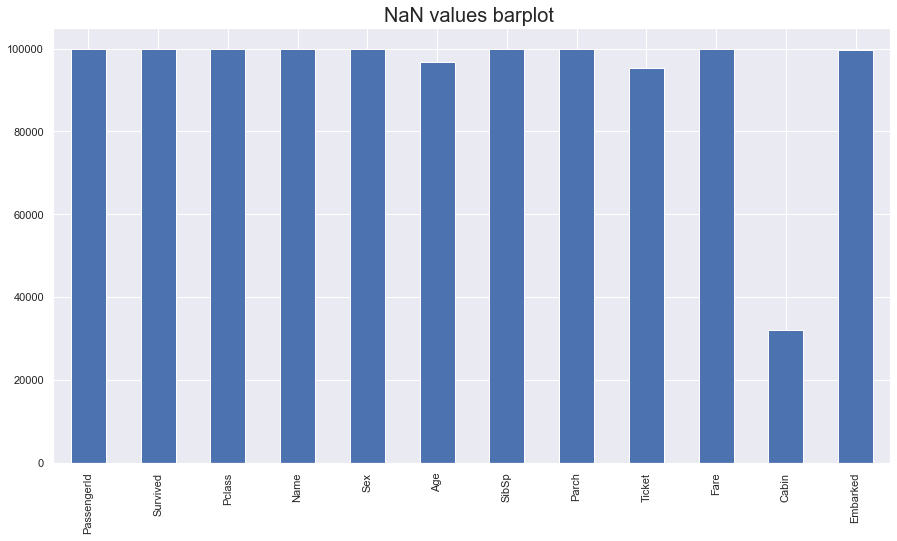

In [17]:
plt.figure(figsize=(15,8))
plt.title("NaN values barplot ", fontsize =20)
data.count().plot(kind='bar')

<AxesSubplot:title={'center':'NaN values heatmap '}>

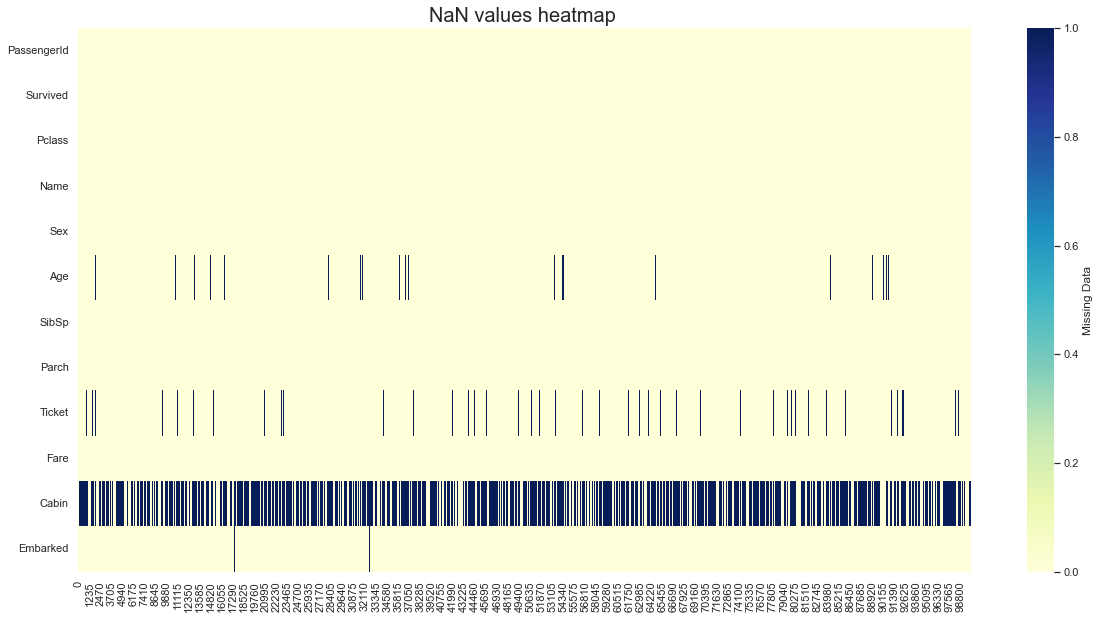

In [18]:
plt.figure(figsize=(20,10))
plt.title("NaN values heatmap ", fontsize =20)
sns.heatmap(data.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

In [19]:
nan_cols = data.isna().sum()
nan_cols = nan_cols[nan_cols > 0].index
for col in nan_cols:
    print(f'{col} has {data[col].isna().sum()} ({100 * data[col].isna().sum() / data.shape[0]}%) missing data')

Age has 3292 (3.292%) missing data
Ticket has 4623 (4.623%) missing data
Fare has 134 (0.134%) missing data
Cabin has 67866 (67.866%) missing data
Embarked has 250 (0.25%) missing data


#### *Let's handle NaN values. We will introduce new category 'Unknown' for missing Cabin and Ticket columns. For the other columns we will drop the raws containing missing values because the persentage of such rows is relatively small comparing to the whole dataset*

In [20]:
data['Ticket'].fillna('Unknown', inplace=True)
data['Cabin'].fillna('Unknown', inplace=True)
data.drop(data[data.Age.isnull()].index, inplace=True)
data.drop(data[data.Fare.isnull()].index, inplace=True)
data.drop(data[data.Embarked.isnull()].index, inplace=True) 

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96332 entries, 2 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  96332 non-null  int32  
 1   Survived     96332 non-null  int8   
 2   Pclass       96332 non-null  int8   
 3   Name         96332 non-null  object 
 4   Sex          96332 non-null  object 
 5   Age          96332 non-null  float32
 6   SibSp        96332 non-null  int8   
 7   Parch        96332 non-null  int8   
 8   Ticket       96332 non-null  object 
 9   Fare         96332 non-null  float32
 10  Cabin        96332 non-null  object 
 11  Embarked     96332 non-null  object 
dtypes: float32(2), int32(1), int8(4), object(5)
memory usage: 5.9+ MB


# Data exploration

In [22]:
data.describe()

PassengerId      Survived        Pclass           Age         SibSp  \
count  96332.000000  96332.000000  96332.000000  96332.000000  96332.000000   
mean   50013.615237      0.428092      2.106392     38.352646      0.398455   
std    28879.980203      0.494805      0.837831     18.314581      0.864654   
min        2.000000      0.000000      1.000000      0.080000      0.000000   
25%    24989.750000      0.000000      1.000000     25.000000      0.000000   
50%    50027.500000      0.000000      2.000000     39.000000      0.000000   
75%    75028.250000      1.000000      3.000000     53.000000      1.000000   
max    99999.000000      1.000000      3.000000     87.000000      8.000000   

              Parch          Fare  
count  96332.000000  96332.000000  
mean       0.455082     43.923111  
std        0.952182     69.523918  
min        0.000000      0.680000  
25%        0.000000     10.030000  
50%        0.000000     24.480000  
75%        1.000000     33.520000  
max        9.000000    744.659973

***Observations:***

1. The oldest passenger is 87 years old
2. The youngest passenger is 0.08 years old
3. Less than half people on the ship survived
4. Max number of siblings\spouses is 8
5. Max number of parents\children is 9
6. The most expernsive fare is 744.659973
7. The cheapest fare is 0.68

## Variables

### PassengerId

In [23]:
print_continious_stats('PassengerId')

Min value: 2
Max value: 99999
Mean value: 50013.61523688909
std value: 28879.98020255907
Count: 96332
nunique value: 96332
nunique(%): 100.0


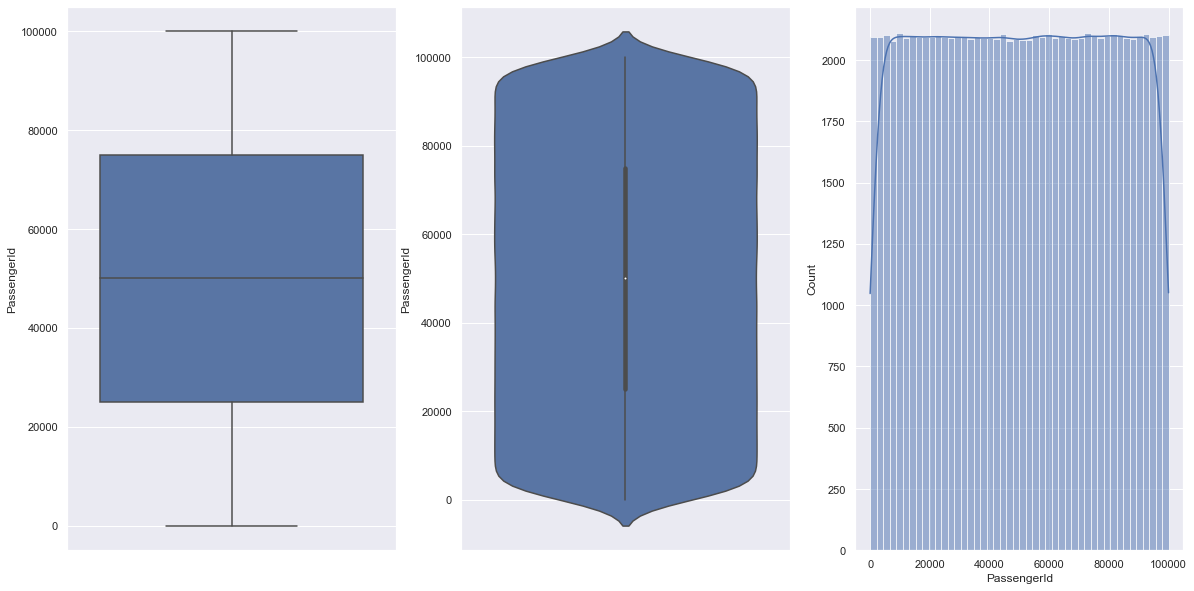

In [24]:
plot_univariate_continious('PassengerId', data)

#### *PassengerId is just unique Identifier. No surprises here.*

### Age 

In [25]:
print_continious_stats('Age')

Min value: 0.07999999821186066
Max value: 87.0
Mean value: 38.35264587402344
std value: 18.3145809173584
Count: 96332
nunique value: 173
nunique(%): 0.1795872607233318


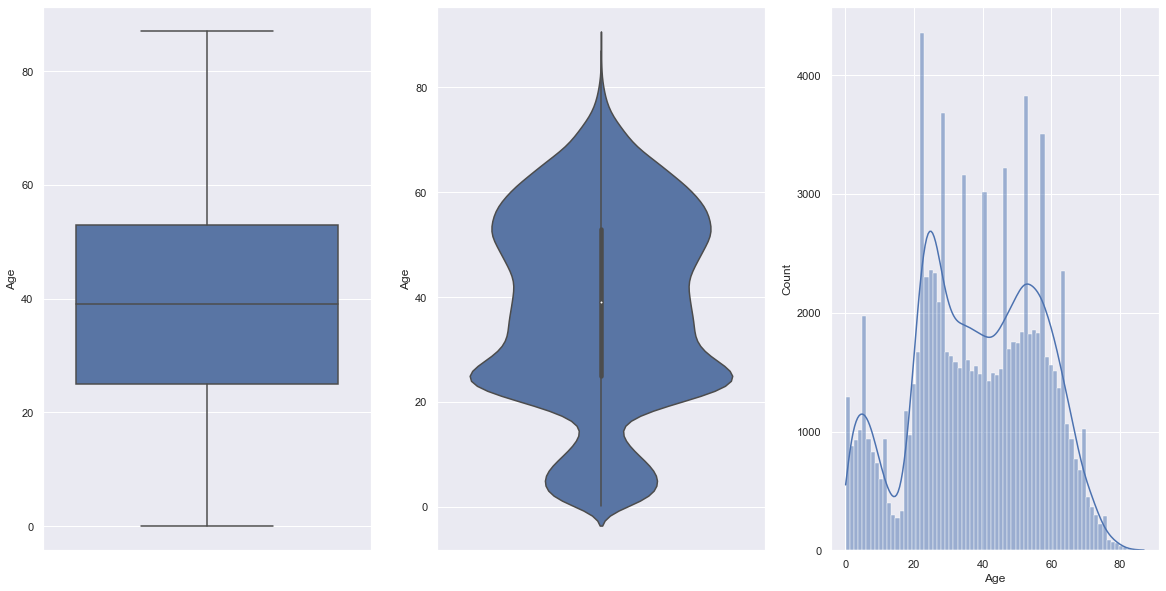

In [26]:
plot_univariate_continious('Age', data)

***There are 3 peaks for Age distribution: around 5, 25 and 55 years
Let's group Age into several categories***

In [27]:
def age_group(row):
    if row['Age'] < 18:
        return 'Child'
    elif row['Age'] >= 18 and row['Age'] <= 40:
        return 'Adult_18_40'
    elif row['Age'] > 40:
        return 'Adult_>40'

In [28]:
data['Age_group'] = data.apply(lambda x: age_group(x), axis=1)

In [29]:
print_categorical_stats('Age_group')

Count: 96332
nunique value: 3
nunique(%): 0.003114229954739858
most popular value: Adult_>40
freqency of most popular value: 45328


<AxesSubplot:title={'center':'Top age groups'}>

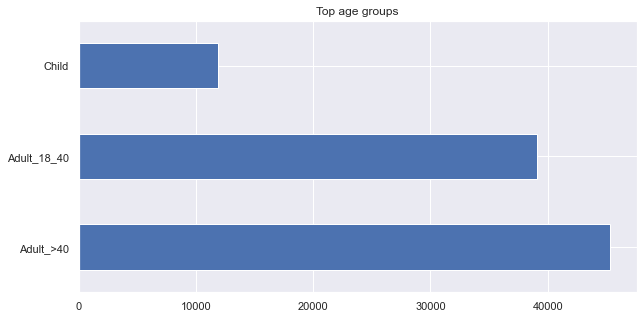

In [30]:
data.Age_group.value_counts().plot(figsize=(10,5), kind='barh', title='Top age groups')

### Fare

In [31]:
print_continious_stats('Fare')

Min value: 0.6800000071525574
Max value: 744.6599731445312
Mean value: 43.92311096191406
std value: 69.52391815185547
Count: 96332
nunique value: 15638
nunique(%): 16.2334426774073


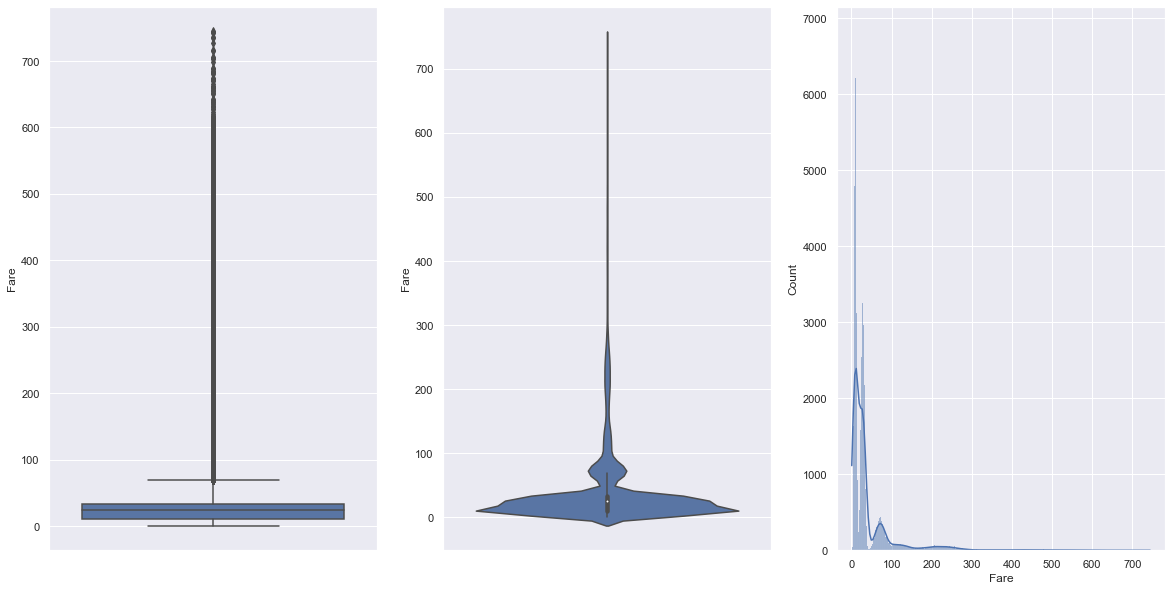

In [32]:
plot_univariate_continious('Fare', data)

#### *There are a lot of outliers. Let's group them into separate category.*

In [33]:
data['Expensive_fare'] = (data.Fare > 80).astype('int8')

In [34]:
data[data.Expensive_fare == 1]

PassengerId  Survived  Pclass                Name     Sex   Age  SibSp  \
19              19         1       1     Hall, Stephanie  female  61.0      0   
25              25         0       1  Dagostino, Christa  female  53.0      1   
27              27         1       1           Way, Tina  female  35.0      0   
33              33         1       1        Roth, Pamela  female  67.0      1   
37              37         1       1       Sell, Dewayne    male  54.0      0   
...            ...       ...     ...                 ...     ...   ...    ...   
99946        99946         1       1         Jack, Karen  female  62.0      0   
99949        99949         1       1      Nolan, Nichole  female  49.0      1   
99960        99960         1       1         Conde, Dale    male  20.0      0   
99966        99966         1       1   Craddock, Chester    male  46.0      1   
99967        99967         0       1     Harrier, Stacey    male  49.0      2   

       Parch        Ticket        Fare   Cabin Embarked    Age_group  \
19         4     PC 174821  205.009995   B7010        Q    Adult_>40   
25         1         11856   82.570000  B11790        Q    Adult_>40   
27         2        476162  154.610001  C20297        C  Adult_18_40   
33         0        448145   97.199997  B16390        Q    Adult_>40   
37         0        207138  228.820007   B7665        S    Adult_>40   
...      ...           ...         ...     ...      ...          ...   
99946      0     PC 168648  209.059998   C4196        C    Adult_>40   
99949      1  S.O.C. 12919  148.729996  B15425        S    Adult_>40   
99960      4     PC 321779  271.779999   B3911        S  Adult_18_40   
99966      0         13554  246.100006   C6653        S    Adult_>40   
99967      0        402064  225.509995   A4590        S    Adult_>40   

       Expensive_fare  
19                  1  
25                  1  
27                  1  
33                  1  
37                  1  
...               ...  
99946               1  
99949               1  
99960               1  
99966               1  
99967               1  

[12224 rows x 14 columns]

<AxesSubplot:title={'center':'Expernsive Fare'}>

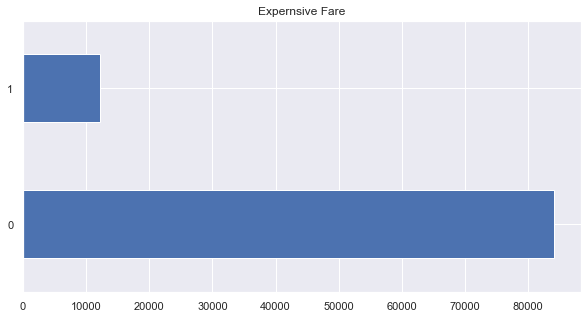

In [35]:
data.Expensive_fare.value_counts().plot(figsize=(10,5), kind='barh', title='Expernsive Fare')

In [36]:
fare_outliers_fraction = data[data.Expensive_fare == 1].Expensive_fare.count() / data.Expensive_fare.count()
print(f'Fare outliers take {round(fare_outliers_fraction, 3) * 100}% of all Fare records')

Fare outliers take 12.7% of all Fare records


### SibSp

In [37]:
print_continious_stats('SibSp')

Min value: 0
Max value: 8
Mean value: 0.398455341942449
std value: 0.8646544679714531
Count: 96332
nunique value: 7
nunique(%): 0.007266536561059669


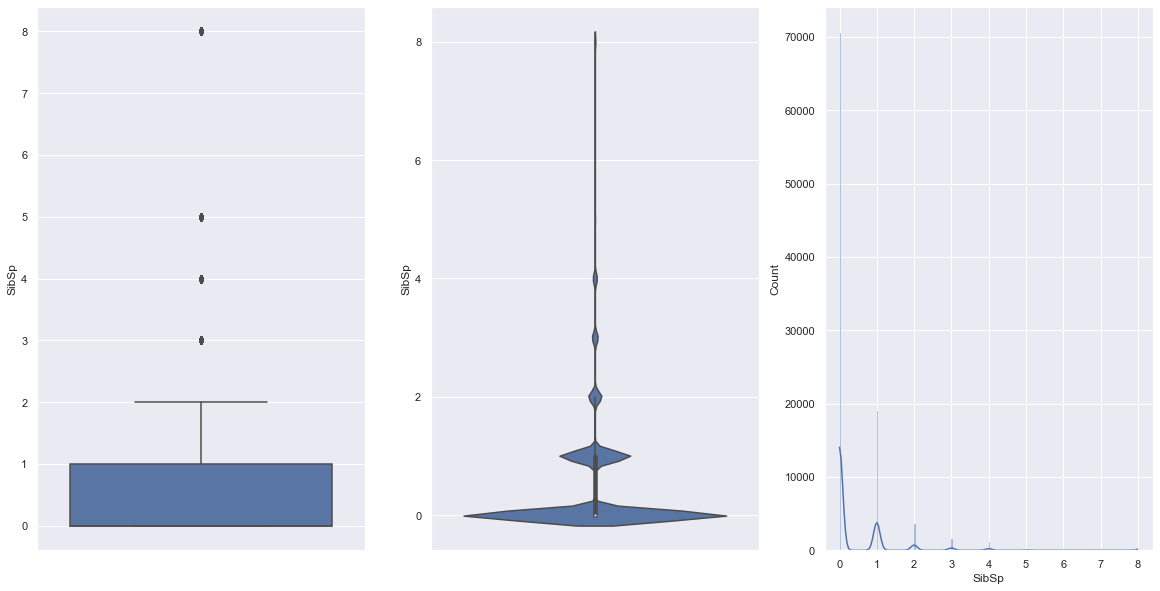

In [38]:
plot_univariate_continious('SibSp', data)

In [39]:
sibsp_outliers_fraction = data[data.SibSp > 2].SibSp.count() / data.SibSp.count()
print(f'SibSp outliers take {round(sibsp_outliers_fraction, 3) * 100}% of all SibSp records')

SibSp outliers take 3.2% of all SibSp records


<AxesSubplot:title={'center':'SibSp'}>

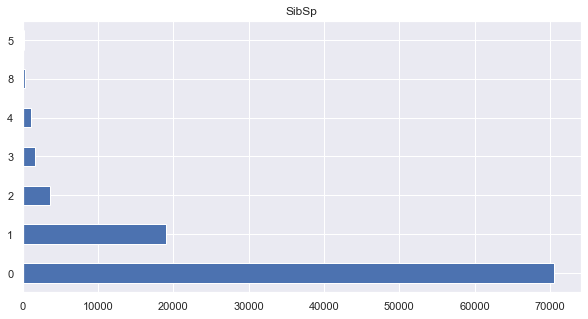

In [40]:
data.SibSp.value_counts().plot(figsize=(10,5), kind='barh', title='SibSp')

***It is possible that some people have 8 SibSp. We will keep outliers for SibSp so far.***`

***Observation:***
The majority of people on the ship didn't have siblings or spouses aboard the Titanic

### Parch

In [41]:
print_continious_stats('Parch')

Min value: 0
Max value: 9
Mean value: 0.45508242328613546
std value: 0.952182471203254
Count: 96332
nunique value: 8
nunique(%): 0.008304613212639622


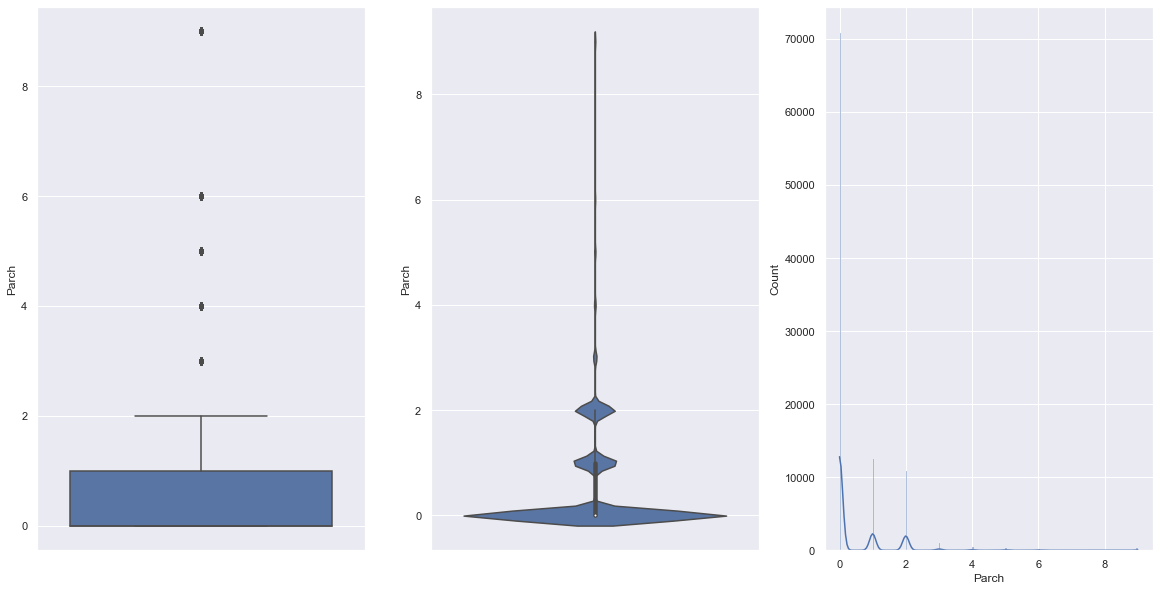

In [42]:
plot_univariate_continious('Parch', data)

In [43]:
parch_outliers_fraction = data[data.Parch > 2].Parch.count() / data.Parch.count()
print(f'Parch outliers take {round(parch_outliers_fraction, 2) * 100}% of all Parch records')

Parch outliers take 2.0% of all Parch records


<AxesSubplot:title={'center':'Parch'}>

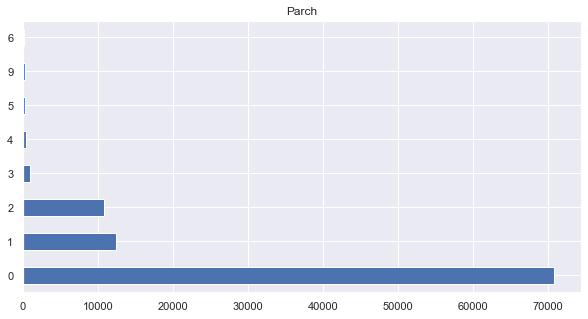

In [44]:
data.Parch.value_counts().plot(figsize=(10,5), kind='barh', title='Parch')

***It is possible that some people have 9 Parch. We will keep outliers for Parch so far.***`

***Observation:***
The majority of people on the ship didn't have parents or children aboard the Titanic

### Name

In [45]:
print_categorical_stats('Name')

Count: 96332
nunique value: 88951
nunique(%): 92.33795623468836
most popular value: Johnson, John
freqency of most popular value: 30


<AxesSubplot:title={'center':'Top 10 names'}>

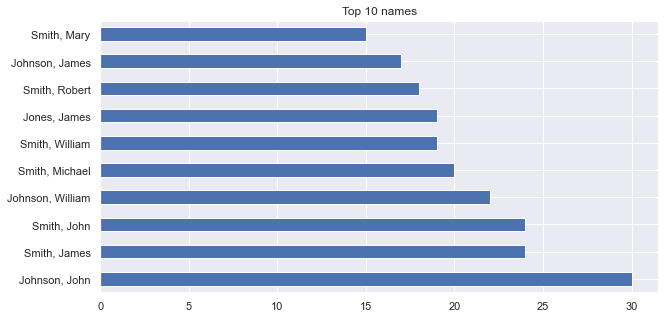

In [46]:
data.Name.value_counts()[:10].plot(figsize=(10,5), kind='barh', title='Top 10 names')

In [47]:
data[data.Name=='Johnson, John']

PassengerId  Survived  Pclass           Name   Sex   Age  SibSp  Parch  \
4676          4676         0       3  Johnson, John  male  76.0      0      0   
5045          5045         0       3  Johnson, John  male  21.0      0      0   
5290          5290         0       2  Johnson, John  male  31.0      0      0   
5523          5523         0       2  Johnson, John  male  68.0      0      0   
7618          7618         0       3  Johnson, John  male  24.0      1      0   
8024          8024         0       2  Johnson, John  male  33.0      0      0   
9177          9177         0       2  Johnson, John  male  70.0      0      0   
13925        13925         0       3  Johnson, John  male  26.0      0      0   
14455        14455         0       2  Johnson, John  male  51.0      0      0   
15201        15201         0       2  Johnson, John  male  57.0      0      2   
15524        15524         0       1  Johnson, John  male  41.0      1      0   
17252        17252         0       3  Johnson, John  male  23.0      0      0   
19056        19056         0       3  Johnson, John  male   8.0      0      0   
31269        31269         1       1  Johnson, John  male  28.0      0      0   
32384        32384         0       3  Johnson, John  male  21.0      0      0   
33425        33425         0       3  Johnson, John  male  22.0      0      0   
37489        37489         0       3  Johnson, John  male  26.0      0      0   
44078        44078         1       1  Johnson, John  male  52.0      0      0   
45799        45799         0       3  Johnson, John  male  34.0      0      0   
49157        49157         1       1  Johnson, John  male  58.0      1      0   
54163        54163         0       3  Johnson, John  male  59.0      0      0   
57925        57925         0       2  Johnson, John  male  14.0      0      1   
65185        65185         0       3  Johnson, John  male  18.0      0      0   
71084        71084         0       3  Johnson, John  male  24.0      0      0   
74829        74829         0       3  Johnson, John  male  57.0      0      0   
80306        80306         0       2  Johnson, John  male  58.0      0      0   
88804        88804         0       3  Johnson, John  male  27.0      0      0   
91782        91782         0       3  Johnson, John  male  61.0      0      0   
95030        95030         0       3  Johnson, John  male  37.0      1      0   
98089        98089         0       1  Johnson, John  male  54.0      0      0   

               Ticket        Fare    Cabin Embarked    Age_group  \
4676    SC/AH 4245034   30.790001  Unknown        S    Adult_>40   
5045            13238    9.260000  Unknown        S  Adult_18_40   
5290     STON/O 26155    5.690000  Unknown        S  Adult_18_40   
5523           215282   11.770000  Unknown        S    Adult_>40   
7618            12180   14.070000  Unknown        S  Adult_18_40   
8024   SC/Paris 20108   24.400000  Unknown        S  Adult_18_40   
9177             6409   27.080000  Unknown        S    Adult_>40   
13925          338045    5.900000  Unknown        S  Adult_18_40   
14455          503268   29.750000  Unknown        S    Adult_>40   
15201          336215   28.700001    A7239        C    Adult_>40   
15524            6887    5.560000  Unknown        S    Adult_>40   
17252           14162   10.600000  Unknown        S  Adult_18_40   
19056          467116   49.470001  Unknown        S        Child   
31269          465838   74.449997   C11706        C  Adult_18_40   
32384           43246   25.340000  Unknown        S  Adult_18_40   
33425        A. 28425    9.400000  Unknown        S  Adult_18_40   
37489  STON/O 3825861    8.950000  Unknown        S  Adult_18_40   
44078          492199   26.850000   A16070        S    Adult_>40   
45799      C.A. 29099    6.690000  Unknown        S  Adult_18_40   
49157          330965  202.470001   B12756        C    Adult_>40   
54163          475133    5.240000  Unknown        S    Adult_>40   

#### ***People with the same name are not duplicates.***

### Ticket

In [48]:
print_categorical_stats('Ticket')

Count: 96332
nunique value: 73026
nunique(%): 75.80658555827763
most popular value: Unknown
freqency of most popular value: 4452


<AxesSubplot:title={'center':'Top 10 tickets'}>

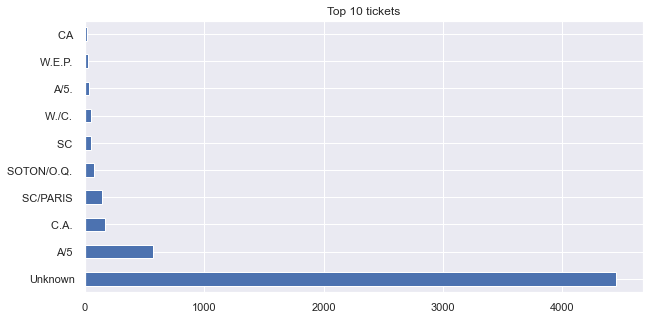

In [49]:
data.Ticket.value_counts()[:10].plot(figsize=(10,5), kind='barh', title='Top 10 tickets')

#### ***The most Ticket values are unknown***

### Cabin

In [50]:
print_categorical_stats('Cabin')

Count: 96332
nunique value: 26176
nunique(%): 27.172694431756838
most popular value: Unknown
freqency of most popular value: 65371


In [51]:
data.Cabin.value_counts()[:10]

Unknown    65371
C19828         6
C19623         5
B18148         5
C11139         5
C13699         5
C12152         5
C9485          5
C14534         5
B11110         5
Name: Cabin, dtype: int64

<AxesSubplot:title={'center':'Top 10 Cabins'}>

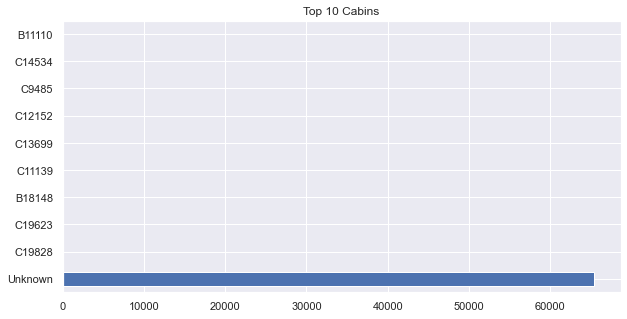

In [52]:
data.Cabin.value_counts()[:10].plot(figsize=(10,5), kind='barh', title='Top 10 Cabins')

#### ***The most Cabin values are unknown***

In [53]:
def cabin_section(raw):
    if raw['Cabin'] == 'Unknown':
        return 'Unknown'
    else:
        return raw['Cabin'][0]

In [54]:
data['Cabin_section'] = data.apply(lambda x: cabin_section(x), axis=1)

In [55]:
print_categorical_stats('Cabin_section')

Count: 96332
nunique value: 9
nunique(%): 0.009342689864219574
most popular value: Unknown
freqency of most popular value: 65371


In [56]:
data.Cabin_section.value_counts()

Unknown    65371
C          11391
B           7145
A           6084
D           3522
E           1690
F            634
G            466
T             29
Name: Cabin_section, dtype: int64

<AxesSubplot:title={'center':'Cabin sections'}>

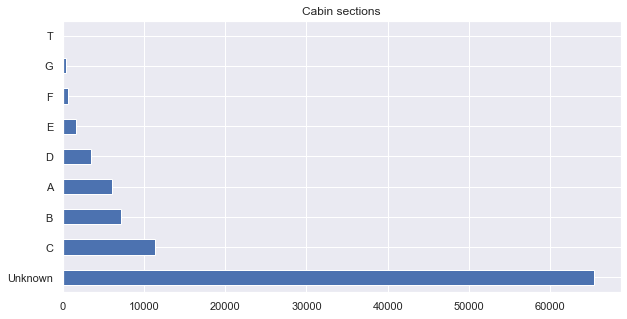

In [57]:
data.Cabin_section.value_counts().plot(figsize=(10,5), kind='barh', title='Cabin sections')

### Pclass 

In [58]:
print_categorical_stats('Pclass')

Count: 96332
nunique value: 3
nunique(%): 0.003114229954739858
most popular value: 3
freqency of most popular value: 39480


In [59]:
data.Pclass.value_counts()

3    39480
1    29231
2    27621
Name: Pclass, dtype: int64

<AxesSubplot:title={'center':'Pclasses'}>

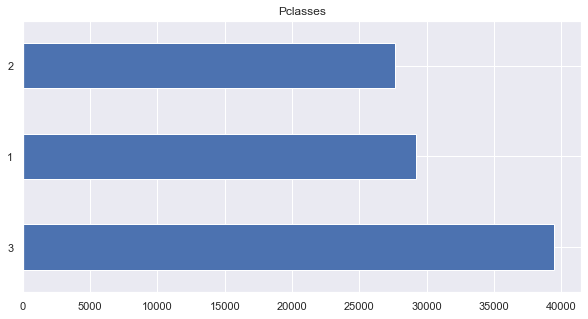

In [60]:
data.Pclass.value_counts().plot(figsize=(10,5), kind='barh', title='Pclasses')

#### ***The most passengers are in 3rd class.***

### Survived

In [61]:
print_categorical_stats('Survived')

Count: 96332
nunique value: 2
nunique(%): 0.0020761533031599055
most popular value: 0
freqency of most popular value: 55093


In [62]:
data.Survived.value_counts()

0    55093
1    41239
Name: Survived, dtype: int64

<AxesSubplot:title={'center':'Survived'}>

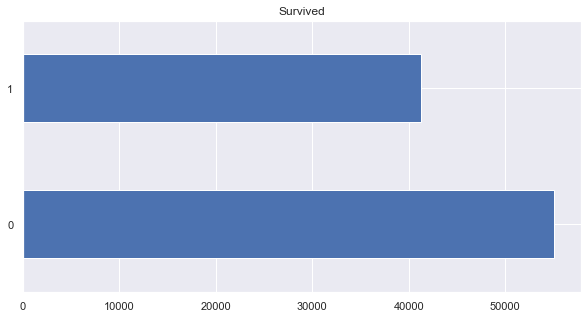

In [63]:
data.Survived.value_counts().plot(figsize=(10,5), kind='barh', title='Survived')

### Sex 

In [64]:
print_categorical_stats('Sex')

Count: 96332
nunique value: 2
nunique(%): 0.0020761533031599055
most popular value: male
freqency of most popular value: 54016


In [65]:
data.Sex.value_counts()

male      54016
female    42316
Name: Sex, dtype: int64

<AxesSubplot:title={'center':'Sex'}>

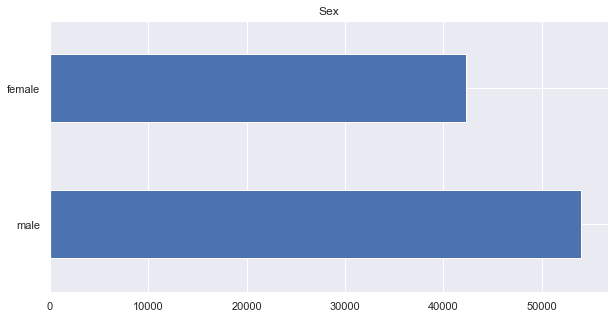

In [66]:
data.Sex.value_counts().plot(figsize=(10,5), kind='barh', title='Sex')

#### ***There were more males than females aboard the Titanic***

### Embarked 

In [67]:
print_categorical_stats('Embarked')

Count: 96332
nunique value: 3
nunique(%): 0.003114229954739858
most popular value: S
freqency of most popular value: 69676


In [68]:
data.Embarked.value_counts()

S    69676
C    21427
Q     5229
Name: Embarked, dtype: int64

<AxesSubplot:title={'center':'Embarked'}>

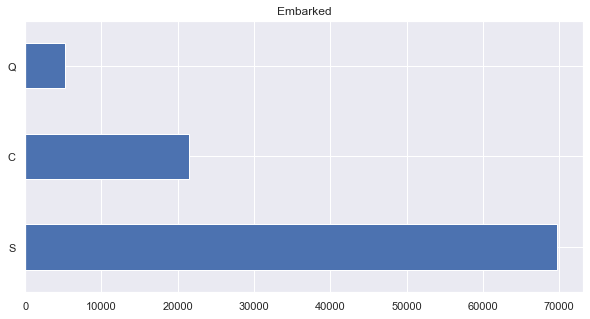

In [69]:
data.Embarked.value_counts().plot(figsize=(10,5), kind='barh', title='Embarked')

#### ***Most of the passengers embarked from Southampton. Least of the passengers embarked from Queenstown***

## Exploring the relationship between each variable and the target(Survived)

In [70]:
cat_features = ['Sex', 'Expensive_fare', 'Pclass', 'Embarked', 'Age_group', 'Cabin_section']
num_features = ['Age', 'Fare', 'SibSp', 'Parch']

### Numeric features

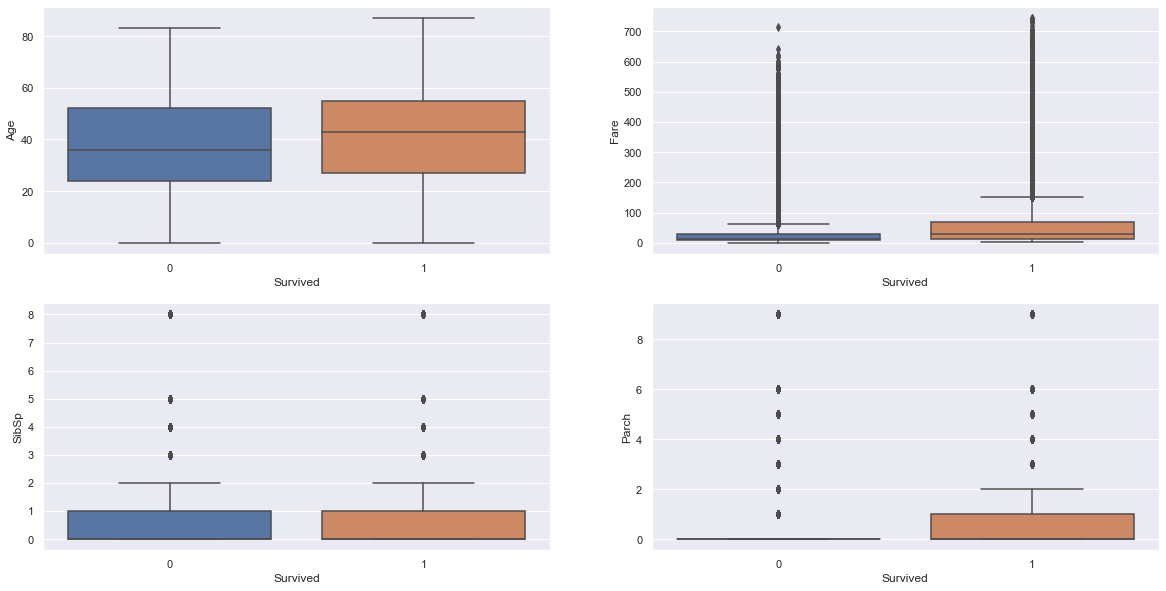

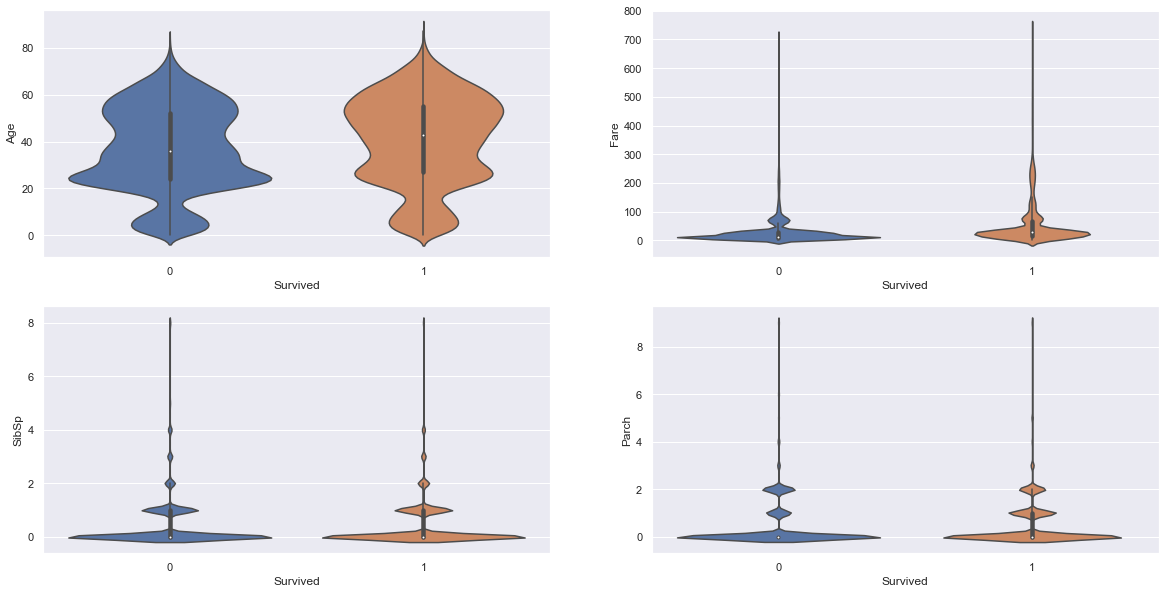

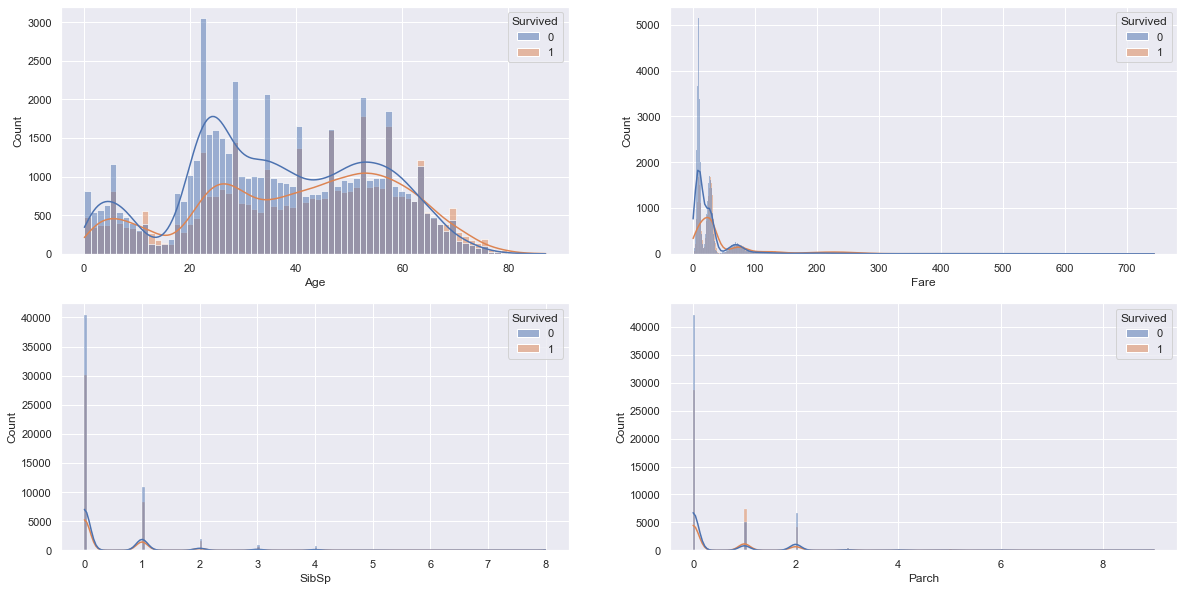

In [71]:
plot_cat_num_boxplots('Survived', num_features, data)
plot_cat_num_violinplots('Survived', num_features, data)
plot_cat_num_histplots('Survived', num_features, data)

***Observations:***

1. The destribution of Age for survived and not survived people slightly differs

2. In general the fare of survived people is more than the fare of not survived people

3. In general the number of Parents\children aboard the Titanic is more for survived than not survived

### Categorical features

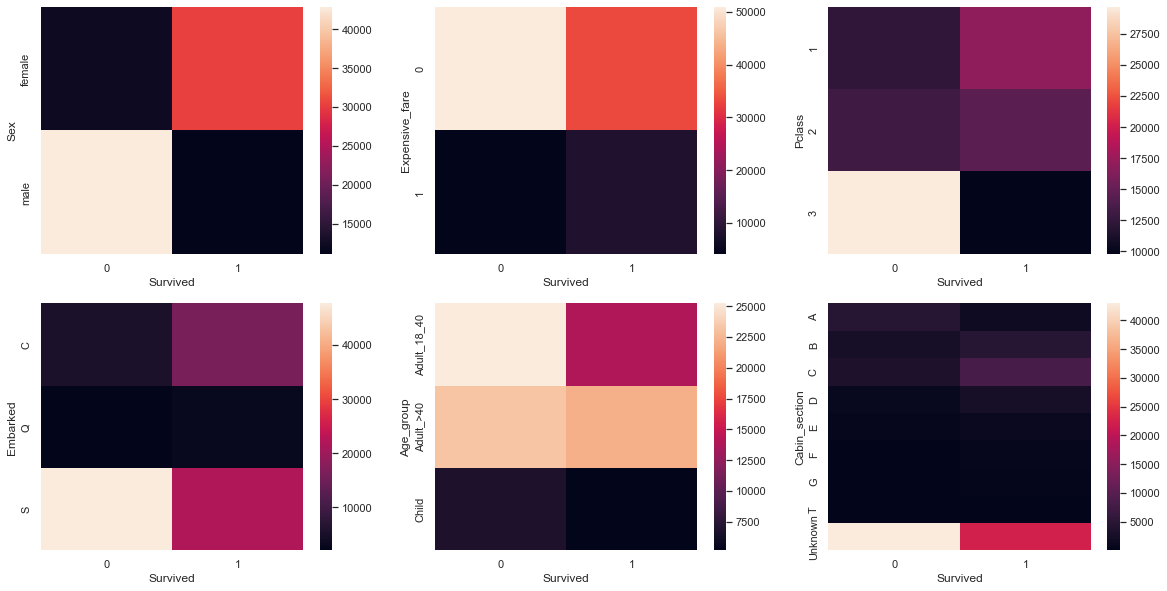

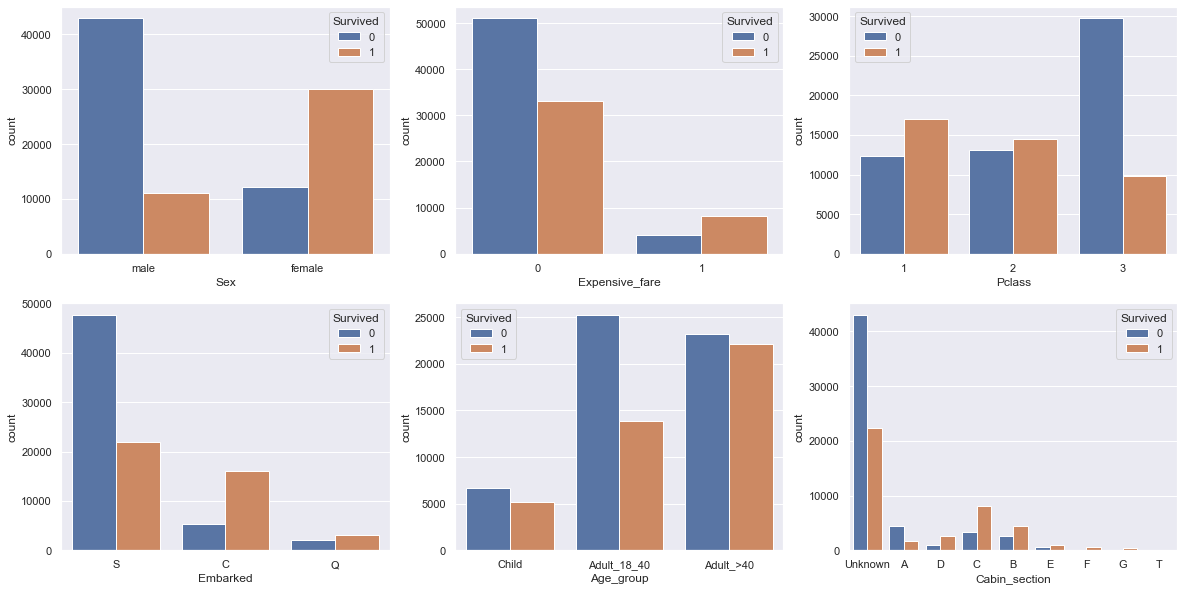

In [72]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for idx, feat in  enumerate(cat_features):
    data_crosstab = pd.crosstab(data[feat], data['Survived'])
    sns.heatmap(data=data_crosstab, ax=axes[idx // 3, idx % 3])

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for idx, feat in  enumerate(cat_features):
    sns.countplot(x=feat, hue='Survived', data=data, ax=axes[idx // 3, idx % 3])

<AxesSubplot:xlabel='Ticket', ylabel='count'>

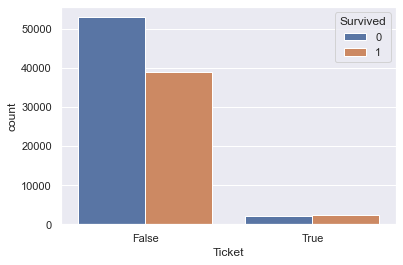

In [73]:
sns.countplot(x=data.Ticket=='Unknown', hue=data['Survived'])

<AxesSubplot:xlabel='Cabin', ylabel='count'>

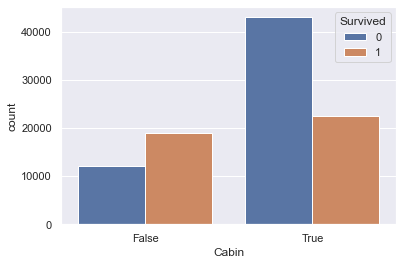

In [74]:
sns.countplot(x=data.Cabin=='Unknown', hue=data['Survived'])

***Observations:***

1. Most females survived despite there were less females than males aboard.
2. Passengers with expensive fare survived more often than passengers with cheap fare
3. number of survived passengers among 1st and 2nd class more than number of passengers in 3rd class.
4. Distributions of Survived passengers differs for Embarked column
5. Passengers embaarked in Cherbourg port have the best survived ration. 
6. Distributions of Survived passengers differs for Cabin_section column
7. Passengers from C Cabin_section has the best chances to survive.
8. the fraction of survived children and adults >40 is bigger than fraction of survived Adults_18_40
9. The fraction of survived passengers with unknown Cabin is less than fraction with given information about Cabin 

## Multiple barplots

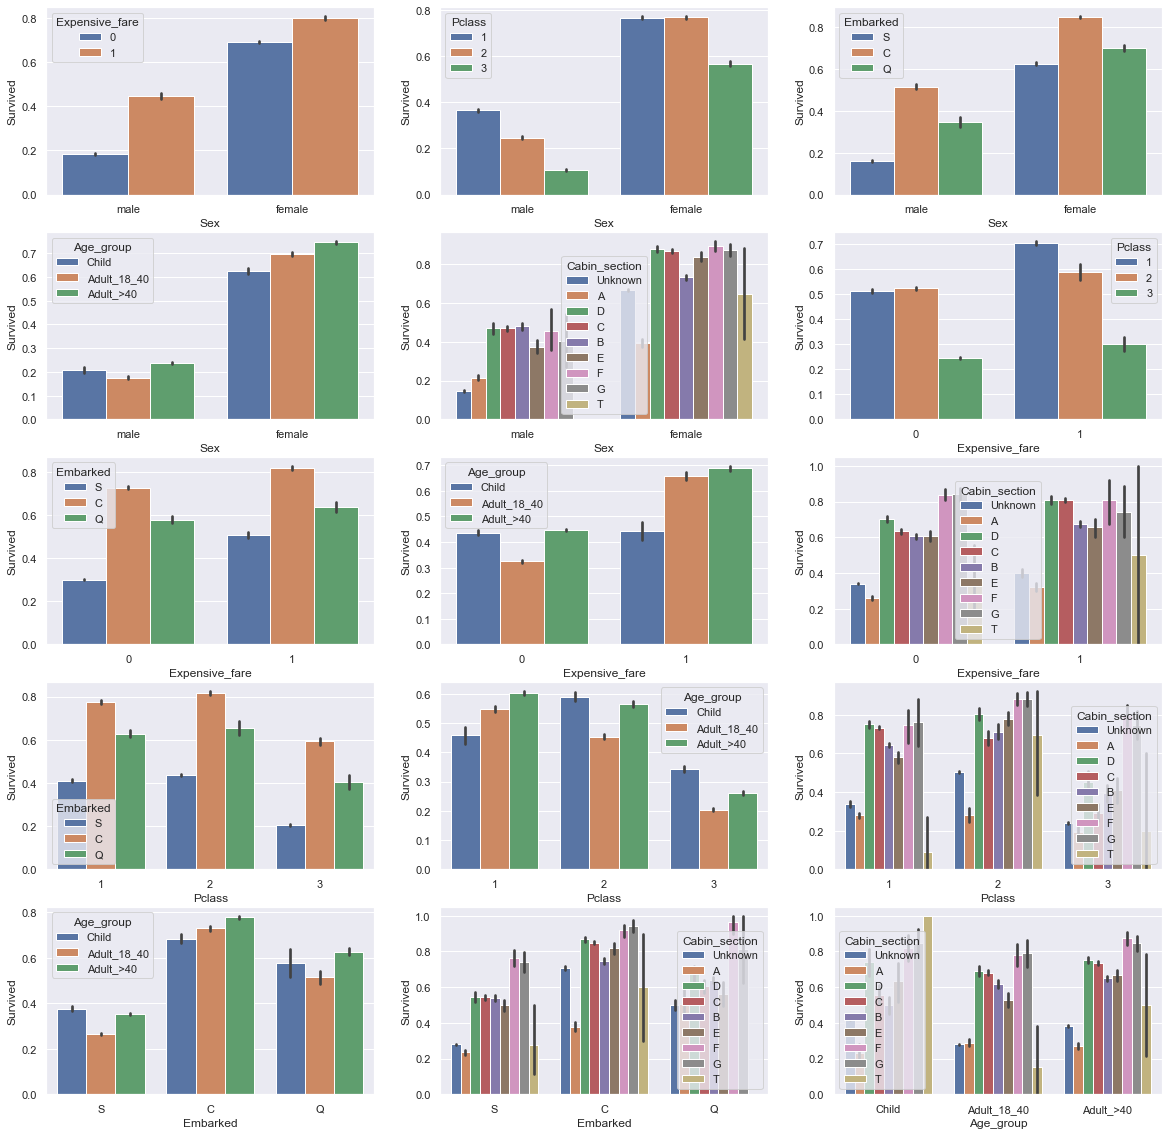

In [75]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 20))

index_count = 0
for i, j in itertools.combinations(cat_features, 2):
    sns.barplot(x=i, y="Survived", hue=j, data=data, ax=axes[index_count // 3, index_count % 3])
    index_count += 1
    

***Observations:***

1. Proportion of survived males wirh expensive fare is greater than survived females with expernsive fare. 
2. Top survived categories for Pclass and Age_group: Adults more than 40 years old from the 1st class and Children from the 2nd class.
3. Top surveived category for Sex and Age_group is females older than 40 years old.

## Relationships between other veriables

### Numeric x Numeric 

<AxesSubplot:title={'center':"Pearson's Correlation"}>

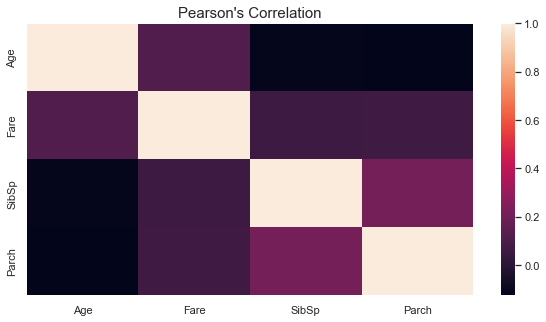

In [76]:
corr_matrix = data[num_features].corr()

plt.figure(figsize=(10,5))
plt.title("Pearson's Correlation", fontsize=15)
sns.heatmap(corr_matrix)

#### ***There is no strong correlation between numeric variables***

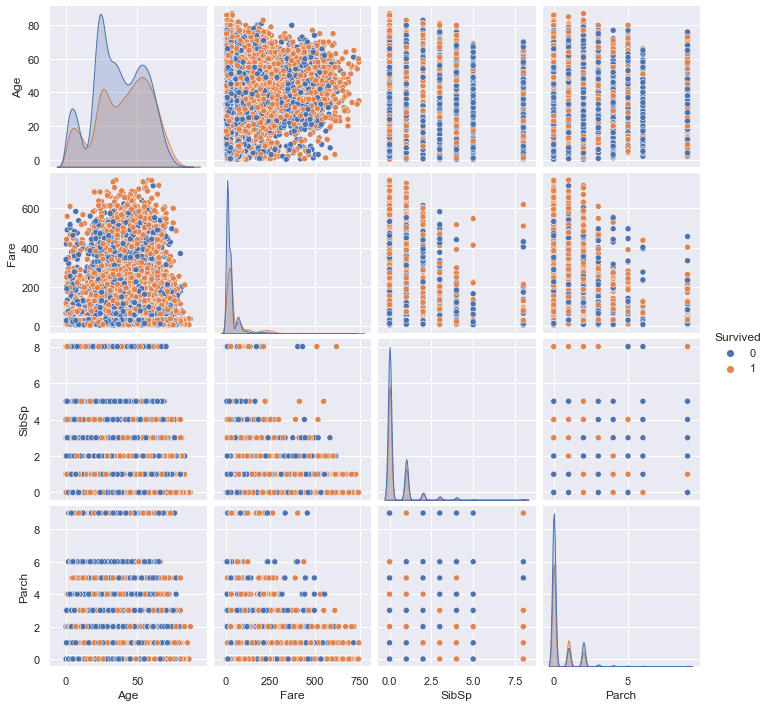

In [77]:
sns.pairplot(data[num_features + ['Survived']], hue='Survived')

### Categorical x Numeric

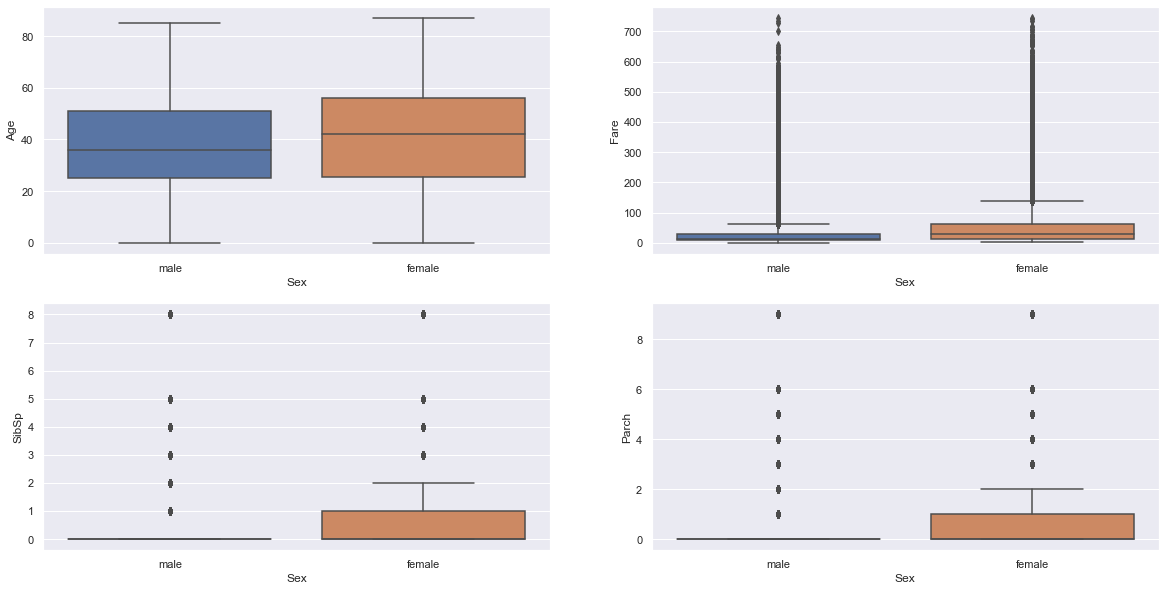

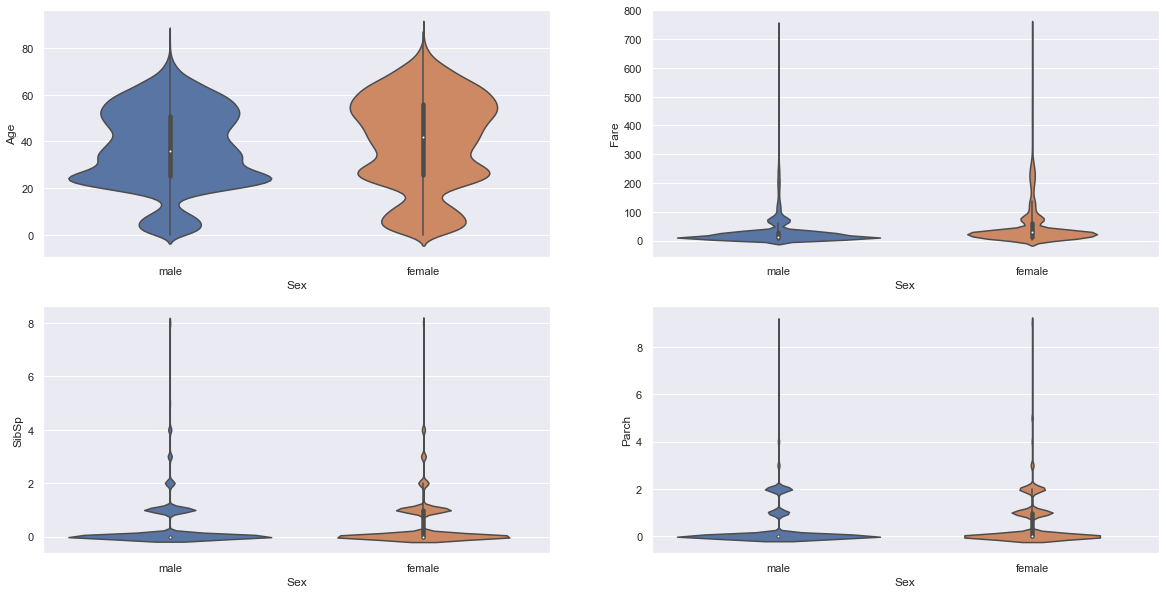

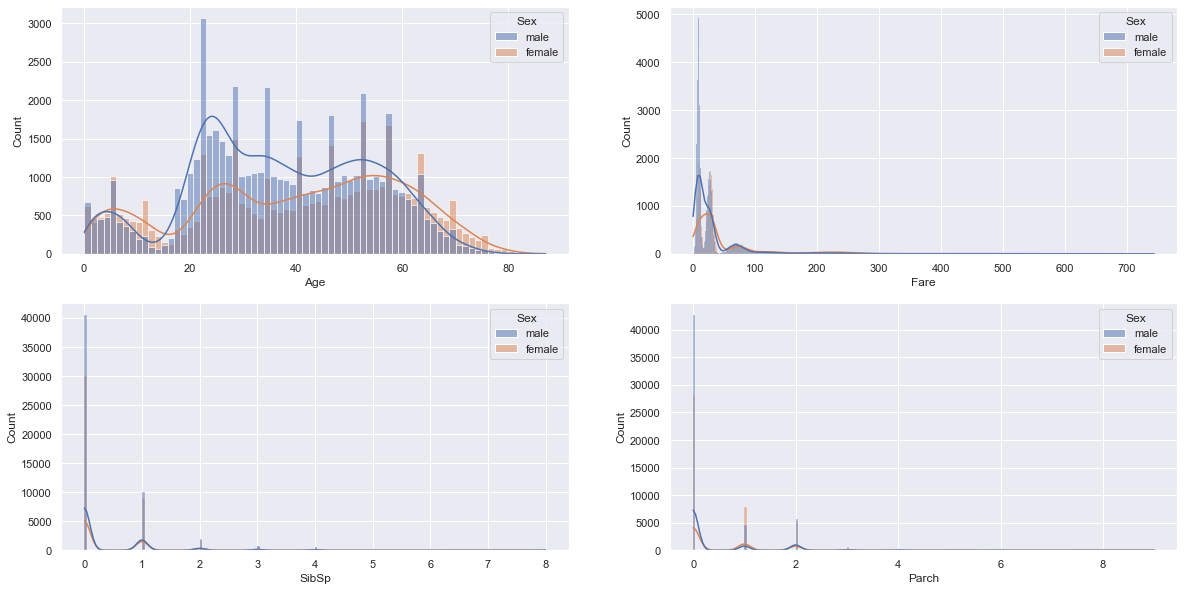

In [78]:
plot_cat_num_boxplots('Sex', num_features, data)
plot_cat_num_violinplots('Sex', num_features, data)
plot_cat_num_histplots('Sex', num_features, data)

***Observations:***
   
1. In general females have more expensive fare than males
2. In general females have more SibSp than males
3. In general females have more Parch than males

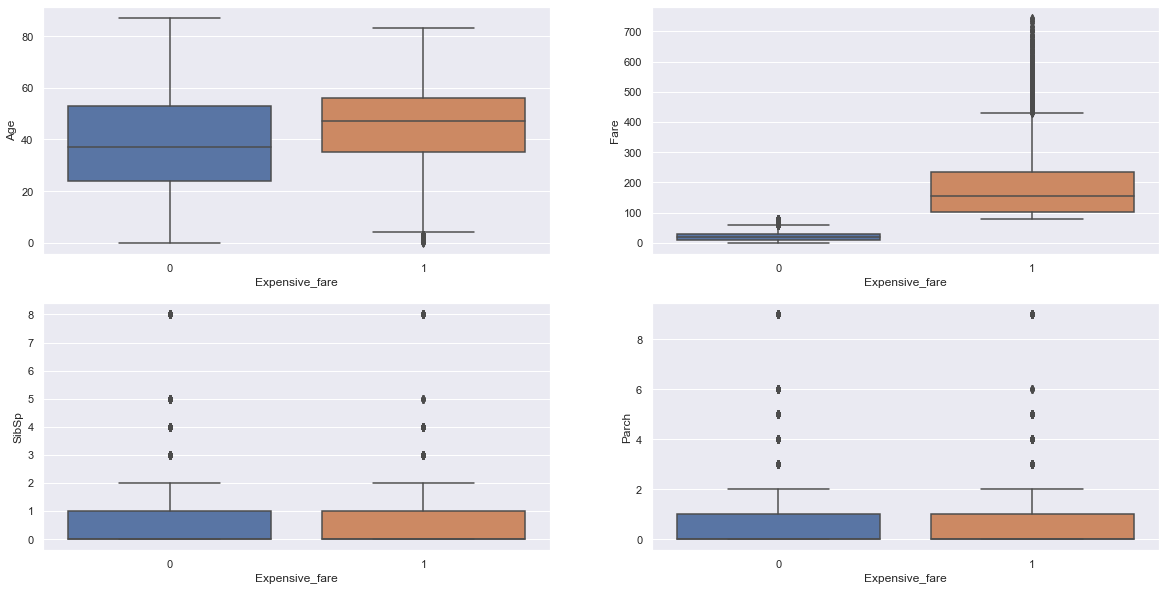

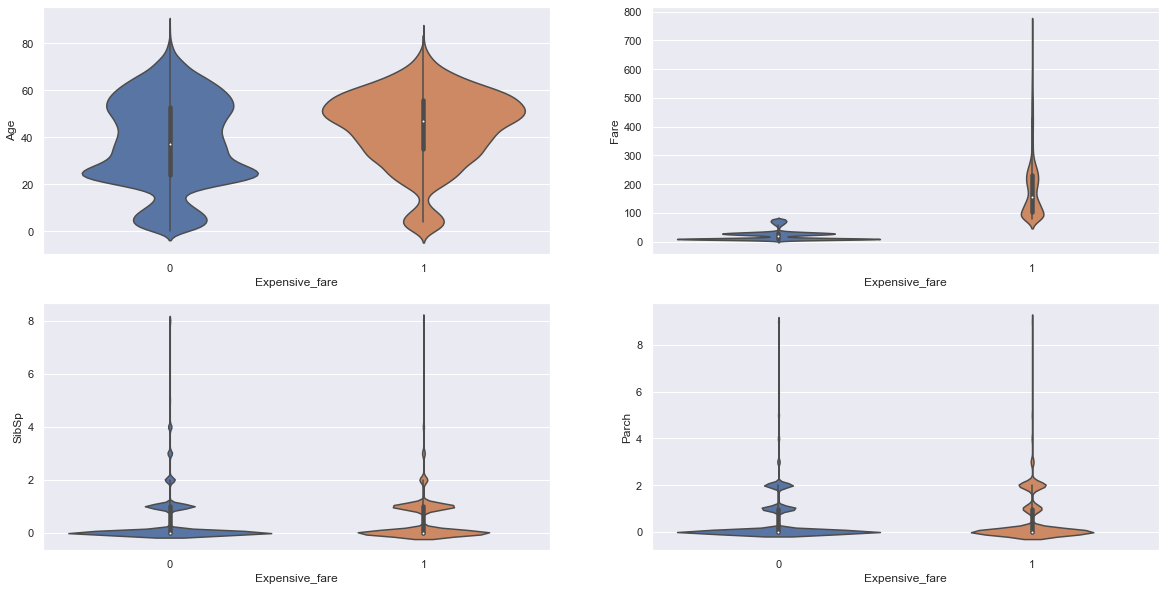

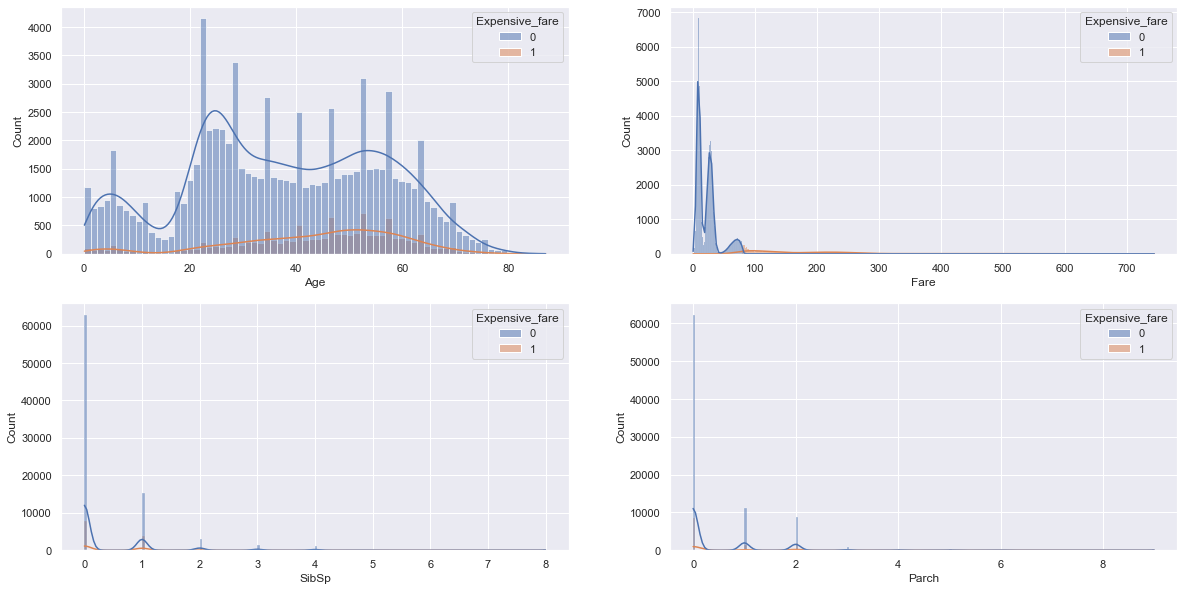

In [79]:
plot_cat_num_boxplots('Expensive_fare', num_features, data)
plot_cat_num_violinplots('Expensive_fare', num_features, data)
plot_cat_num_histplots('Expensive_fare', num_features, data)

***Observations:***
    
1. In general owners of expernsive fare are older. 

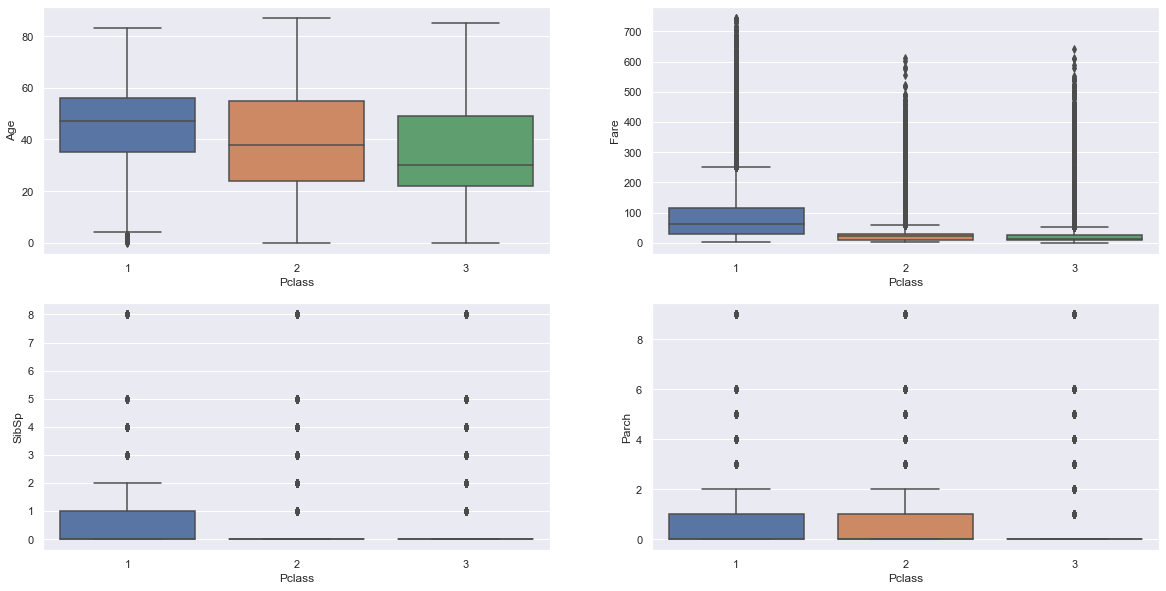

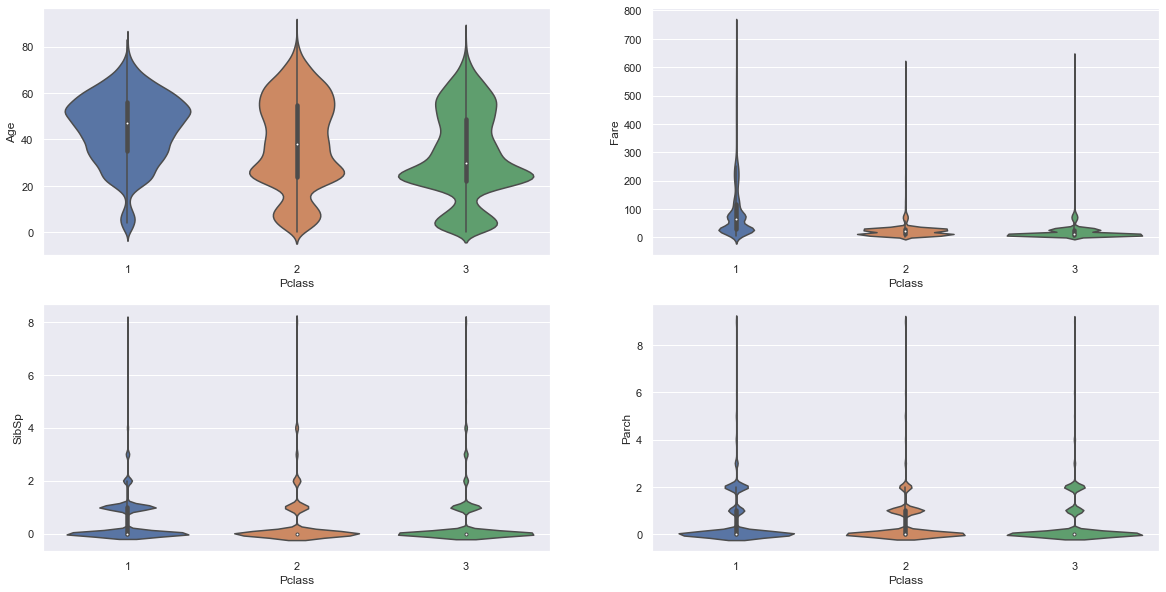

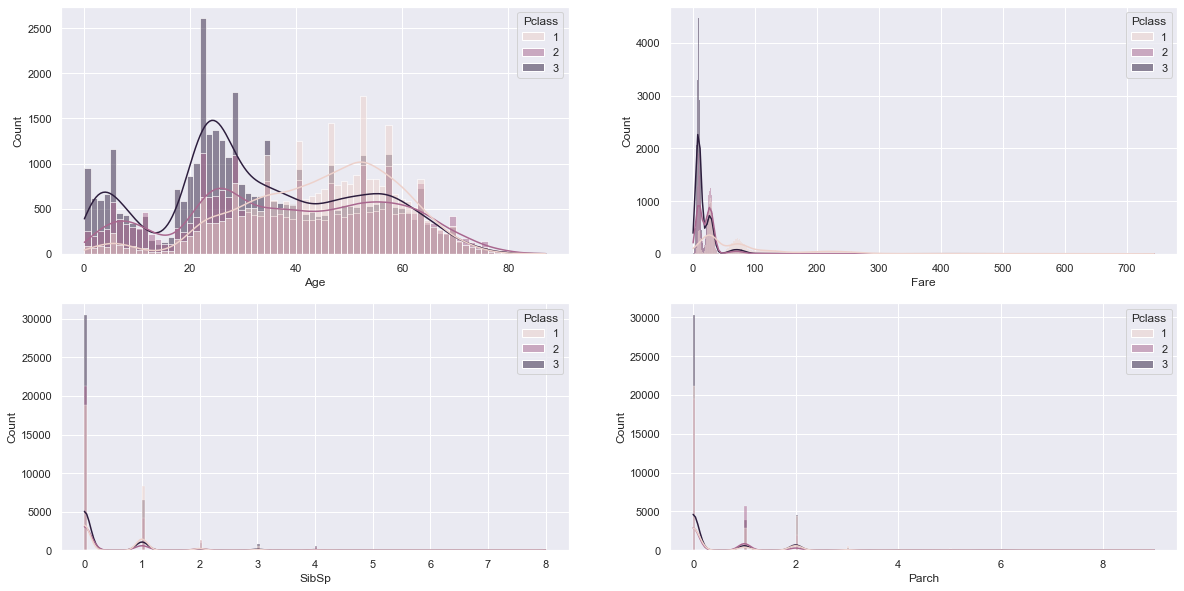

In [80]:
plot_cat_num_boxplots('Pclass', num_features, data)
plot_cat_num_violinplots('Pclass', num_features, data)
plot_cat_num_histplots('Pclass', num_features, data)

***Observations:***

1. In general the passengers of the 1st class are older than passengers of the 2nd class
2. In general the passengers of the 2nd class are older than passengers of the 3rd class
3. In general passengers of the 1st class have more expensive fares than 2nd and 3rd classes
4. In general passnegers of the 1st class have more SibSp than passengers of the other classes
5. In general passengers of the 1st and the 2nd class have more Parch than passengers of the 3rd class

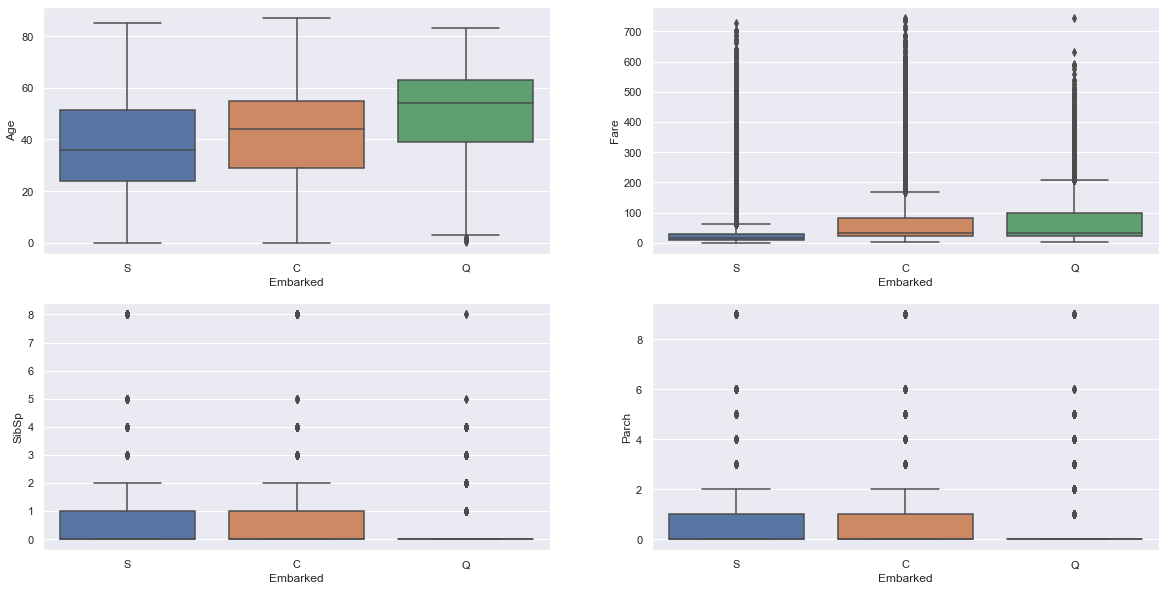

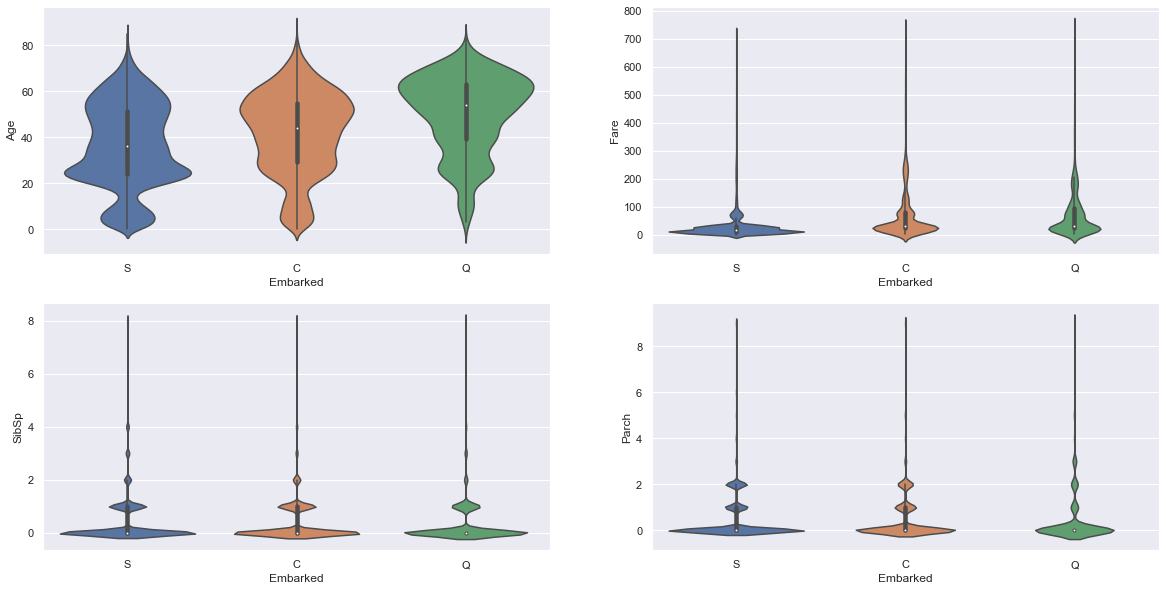

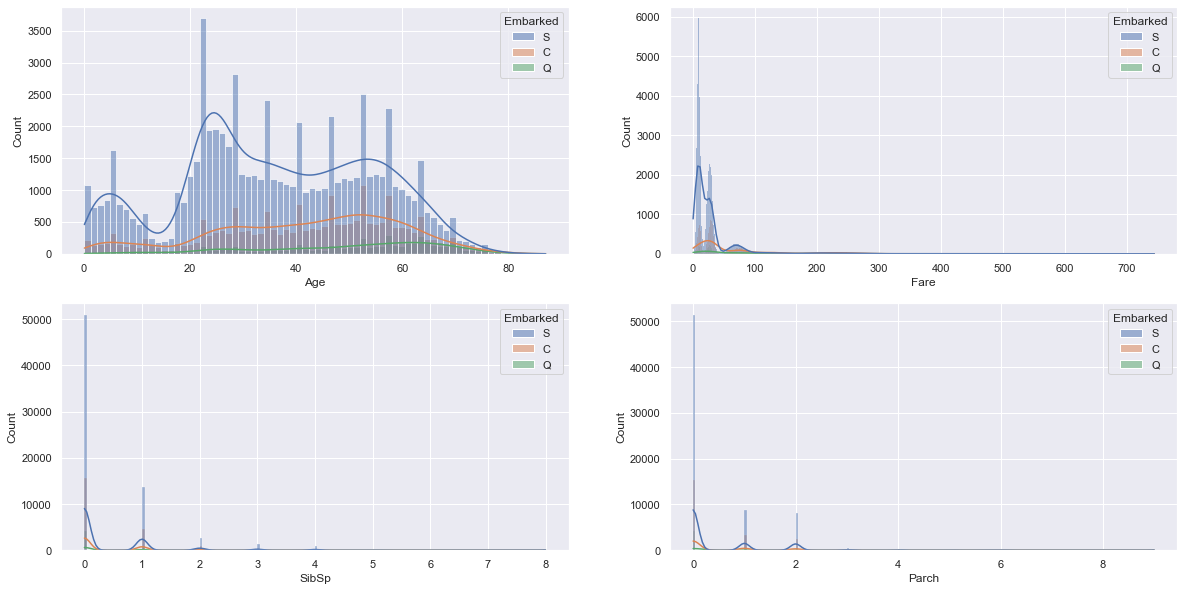

In [81]:
plot_cat_num_boxplots('Embarked', num_features, data)
plot_cat_num_violinplots('Embarked', num_features, data)
plot_cat_num_histplots('Embarked', num_features, data)

***Observations***

1. In general passengers embarked from the Queenstown port are older than from the other ports
2. In general passengers embarked from the Southampton port are younger than from the other ports.
3. Passengers from the Southampton port have the cheapest fares in general.
4. Passengers from the Queenstown port have less SibSp and Parch comparing to the other ports.

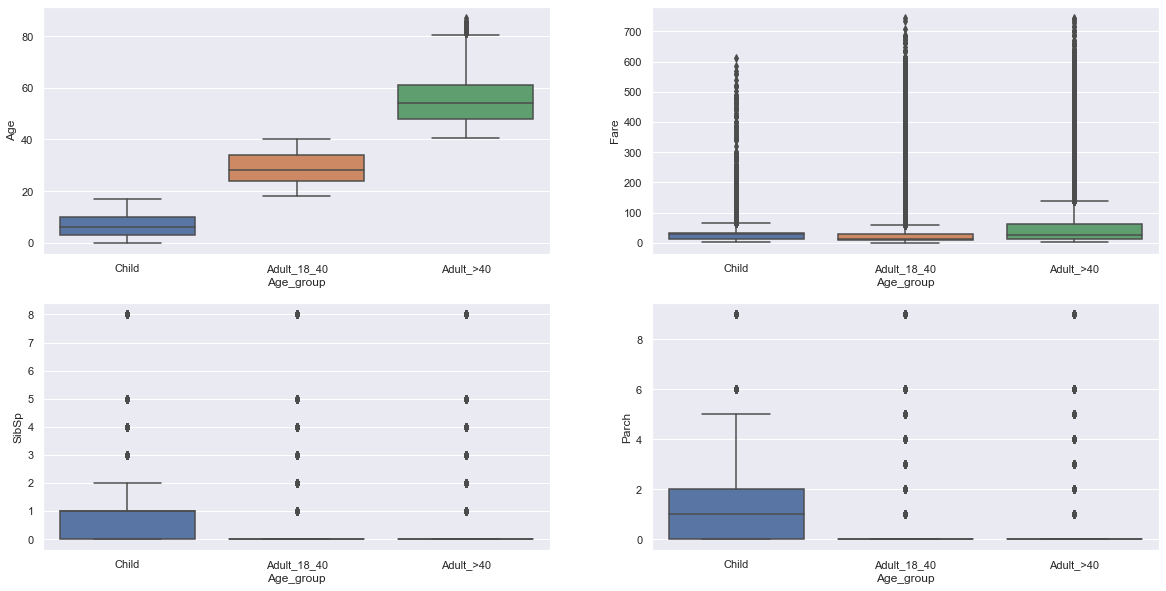

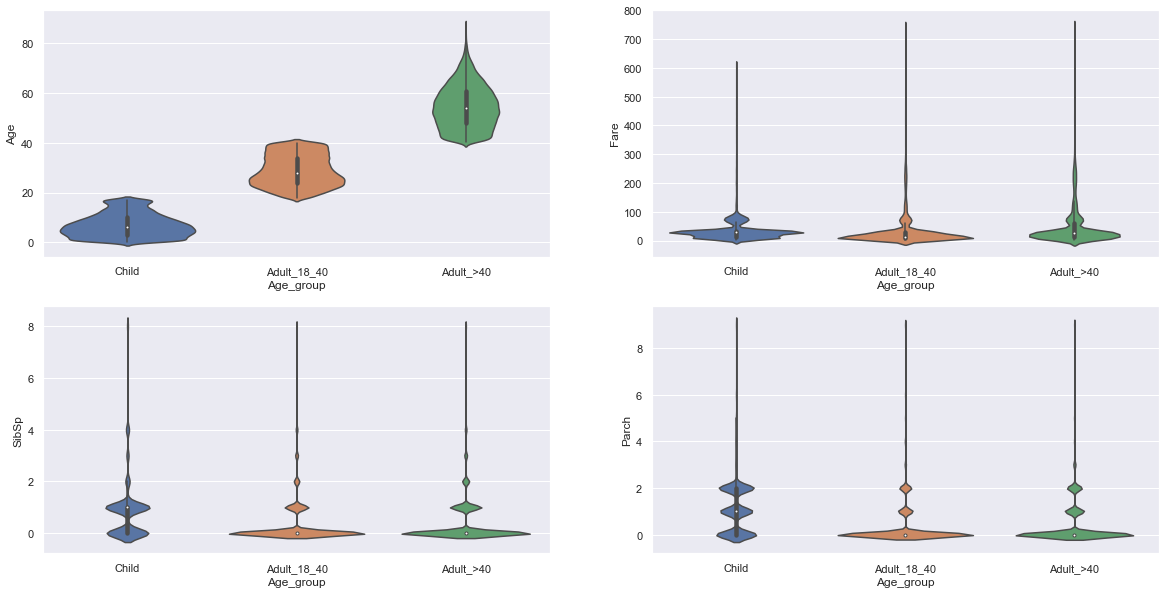

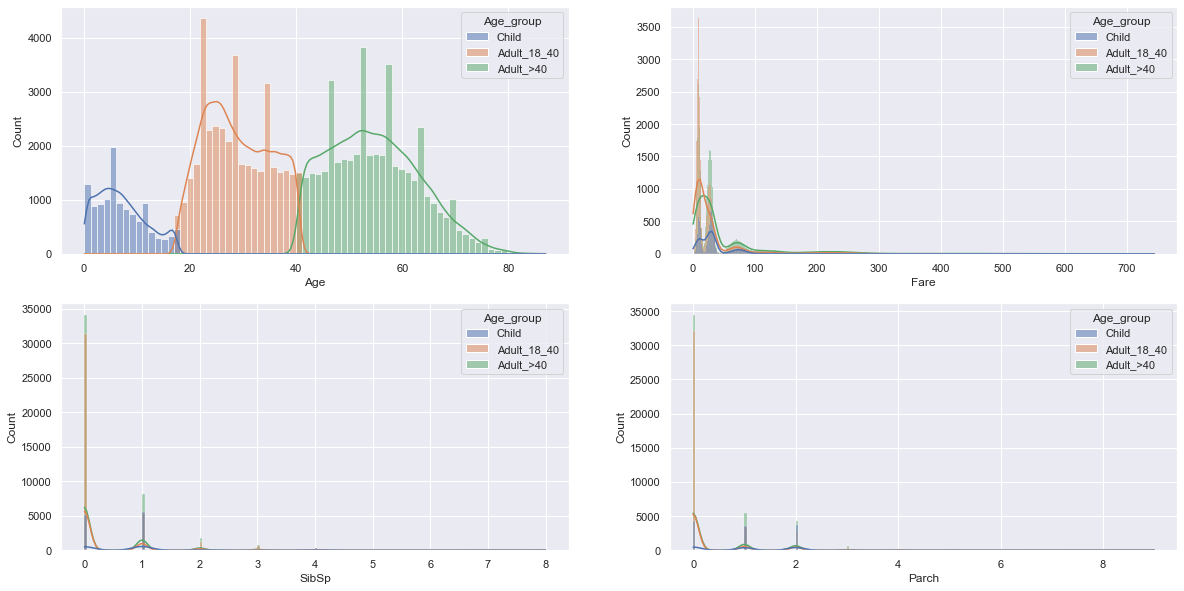

In [82]:
plot_cat_num_boxplots('Age_group', num_features, data)
plot_cat_num_violinplots('Age_group', num_features, data)
plot_cat_num_histplots('Age_group', num_features, data)

***Observations:***

1. Children have the most number of SibSp and Parch in general
2. In general adult>40 have more expensive fares than other age categories

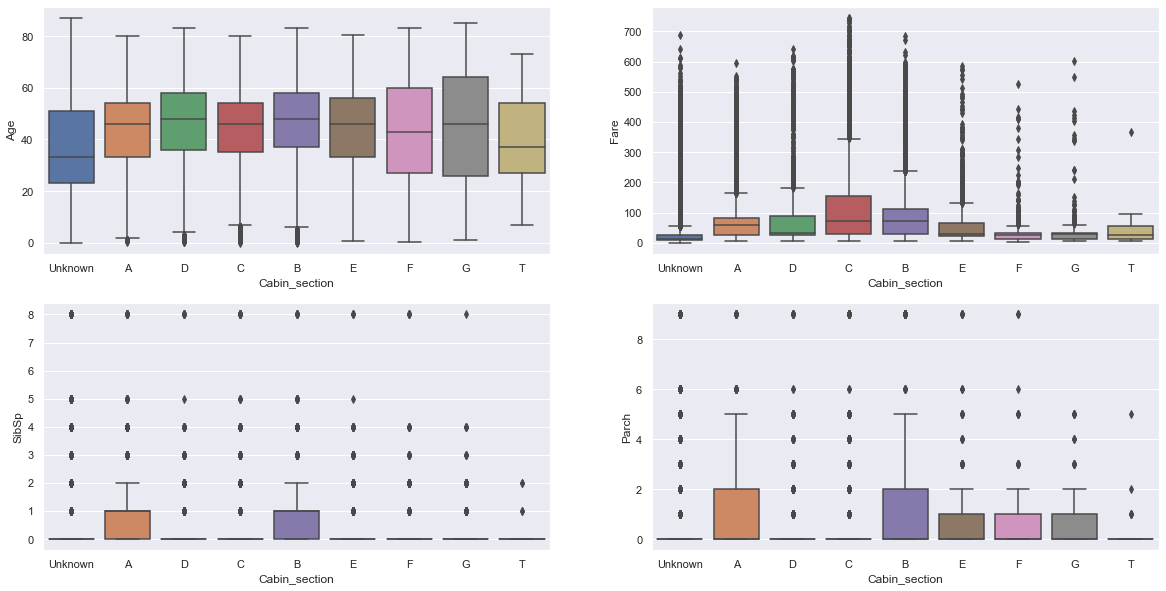

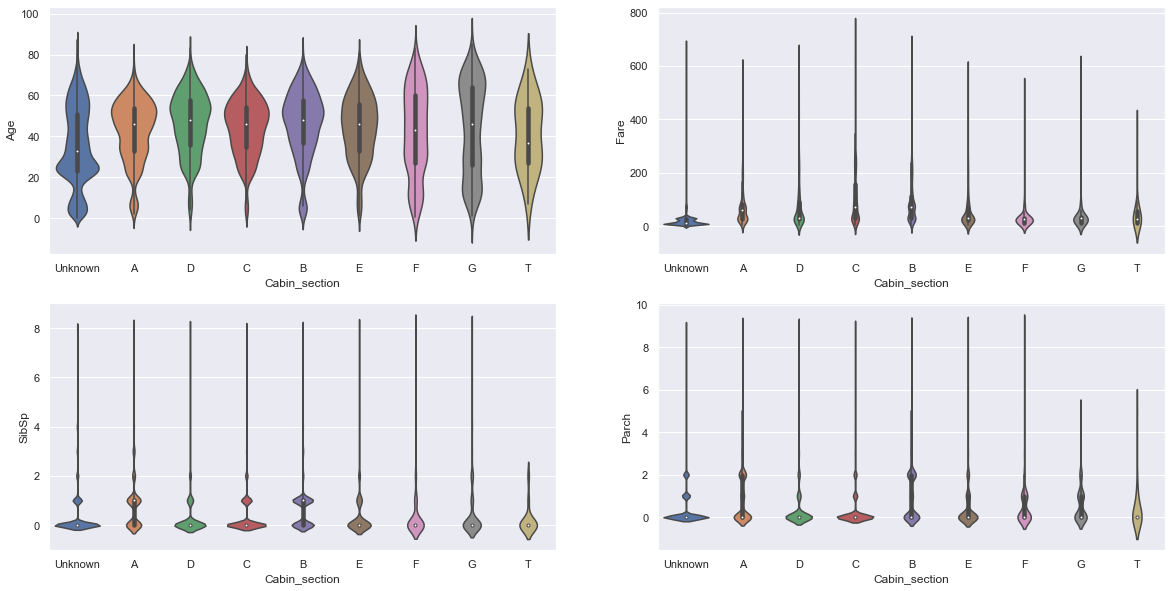

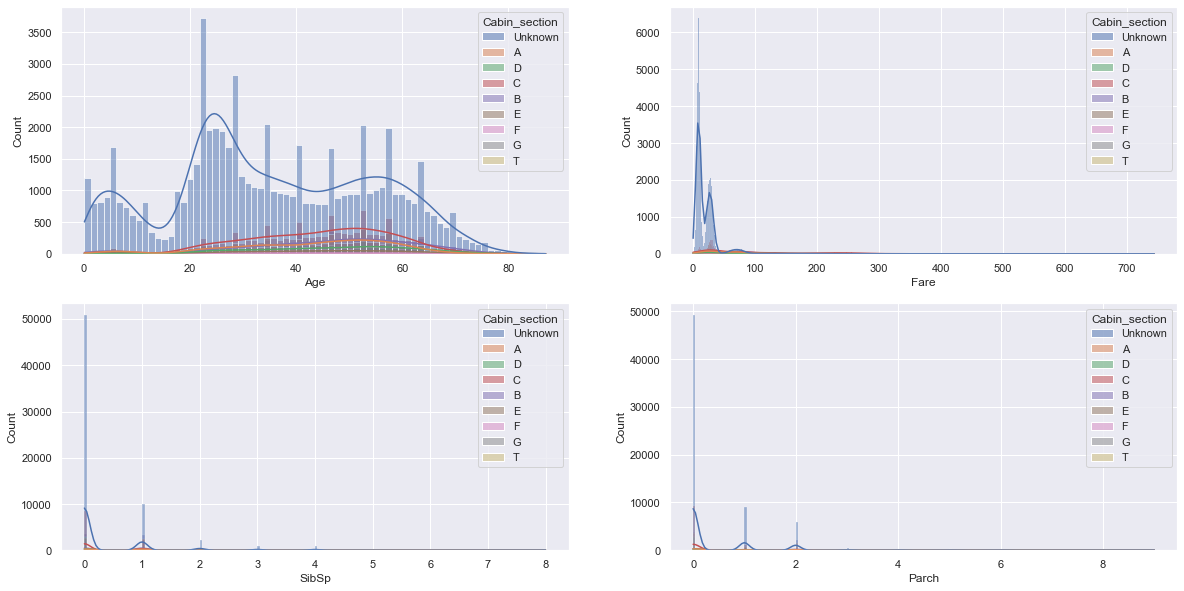

In [83]:
plot_cat_num_boxplots('Cabin_section', num_features, data)
plot_cat_num_violinplots('Cabin_section', num_features, data)
plot_cat_num_histplots('Cabin_section', num_features, data)

***Observations:***

1. Passengers from cabin section C have the most expensive fares in general.
2. Passengers from cabins A and B have the biggest numbers of SibSp and Parch

### Categorical x Categorical

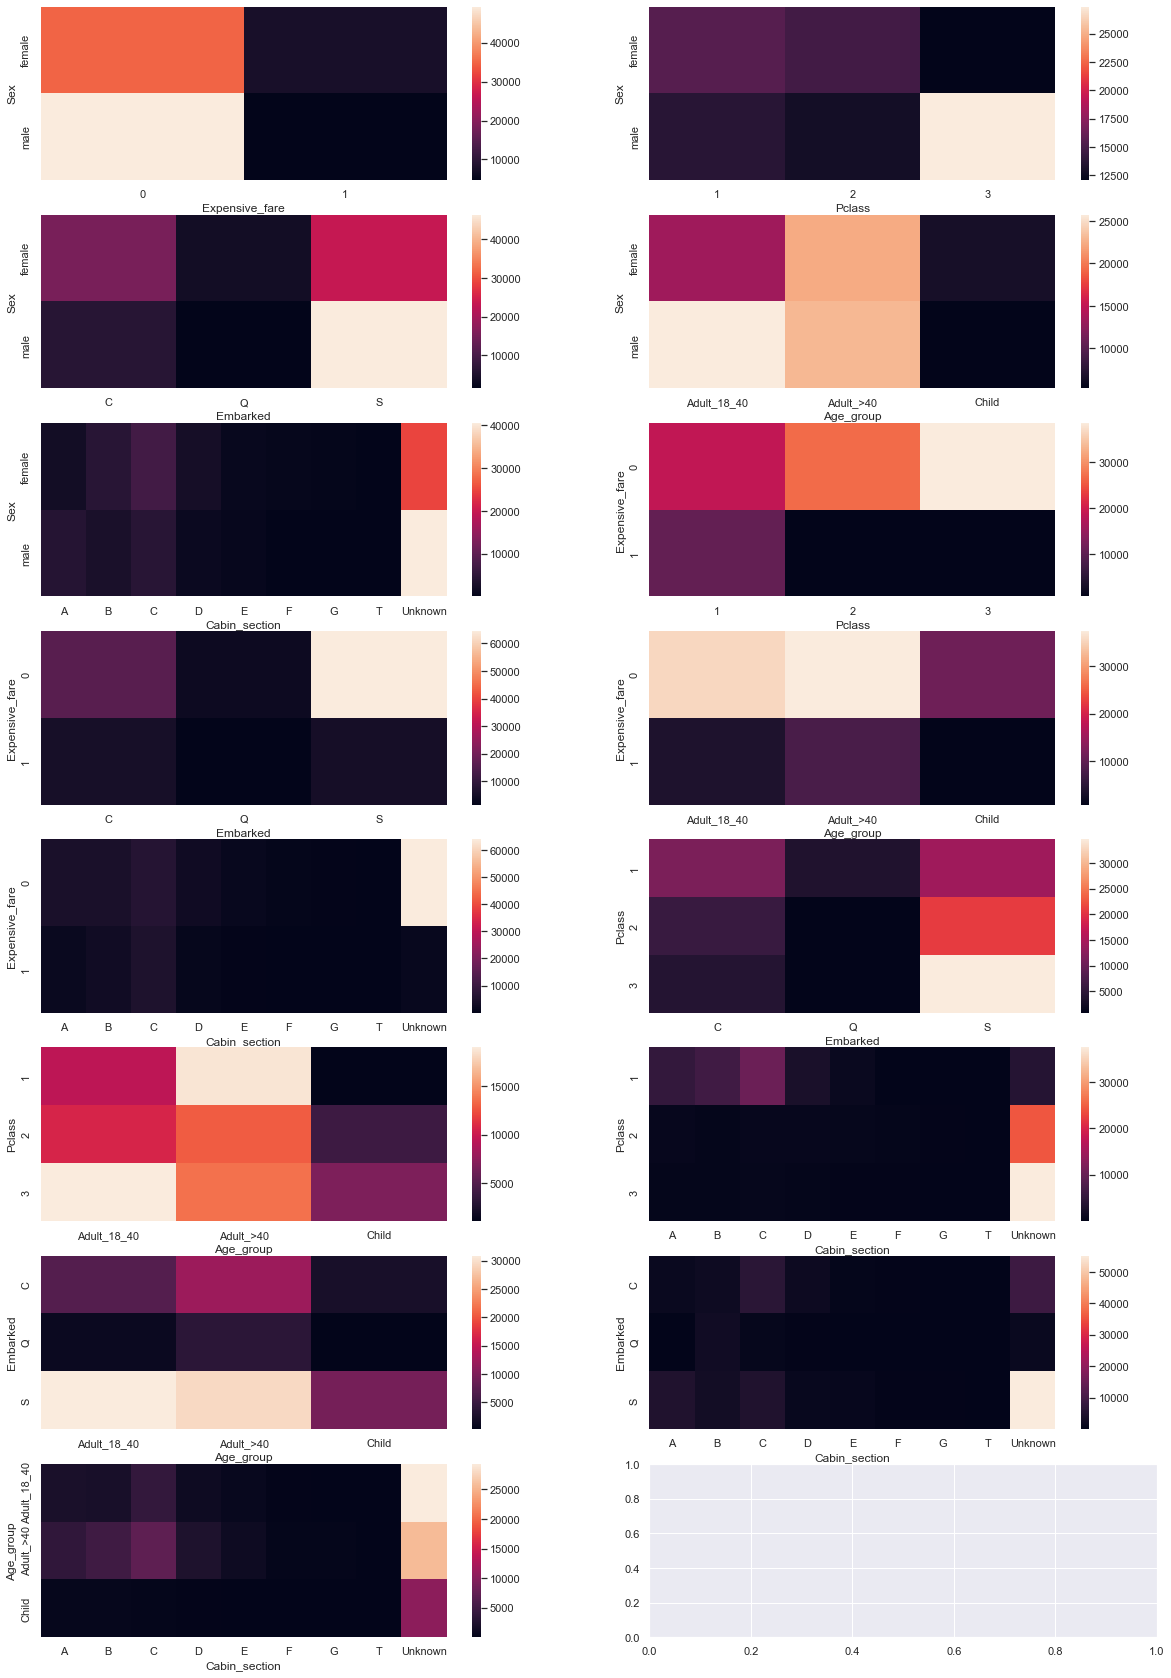

In [84]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20, 30))

idx = 0
for i, j in itertools.combinations(cat_features, 2):
    data_crosstab = pd.crosstab(data[i], data[j])
    sns.heatmap(data=data_crosstab, ax=axes[idx // 2, idx % 2])
    idx += 1

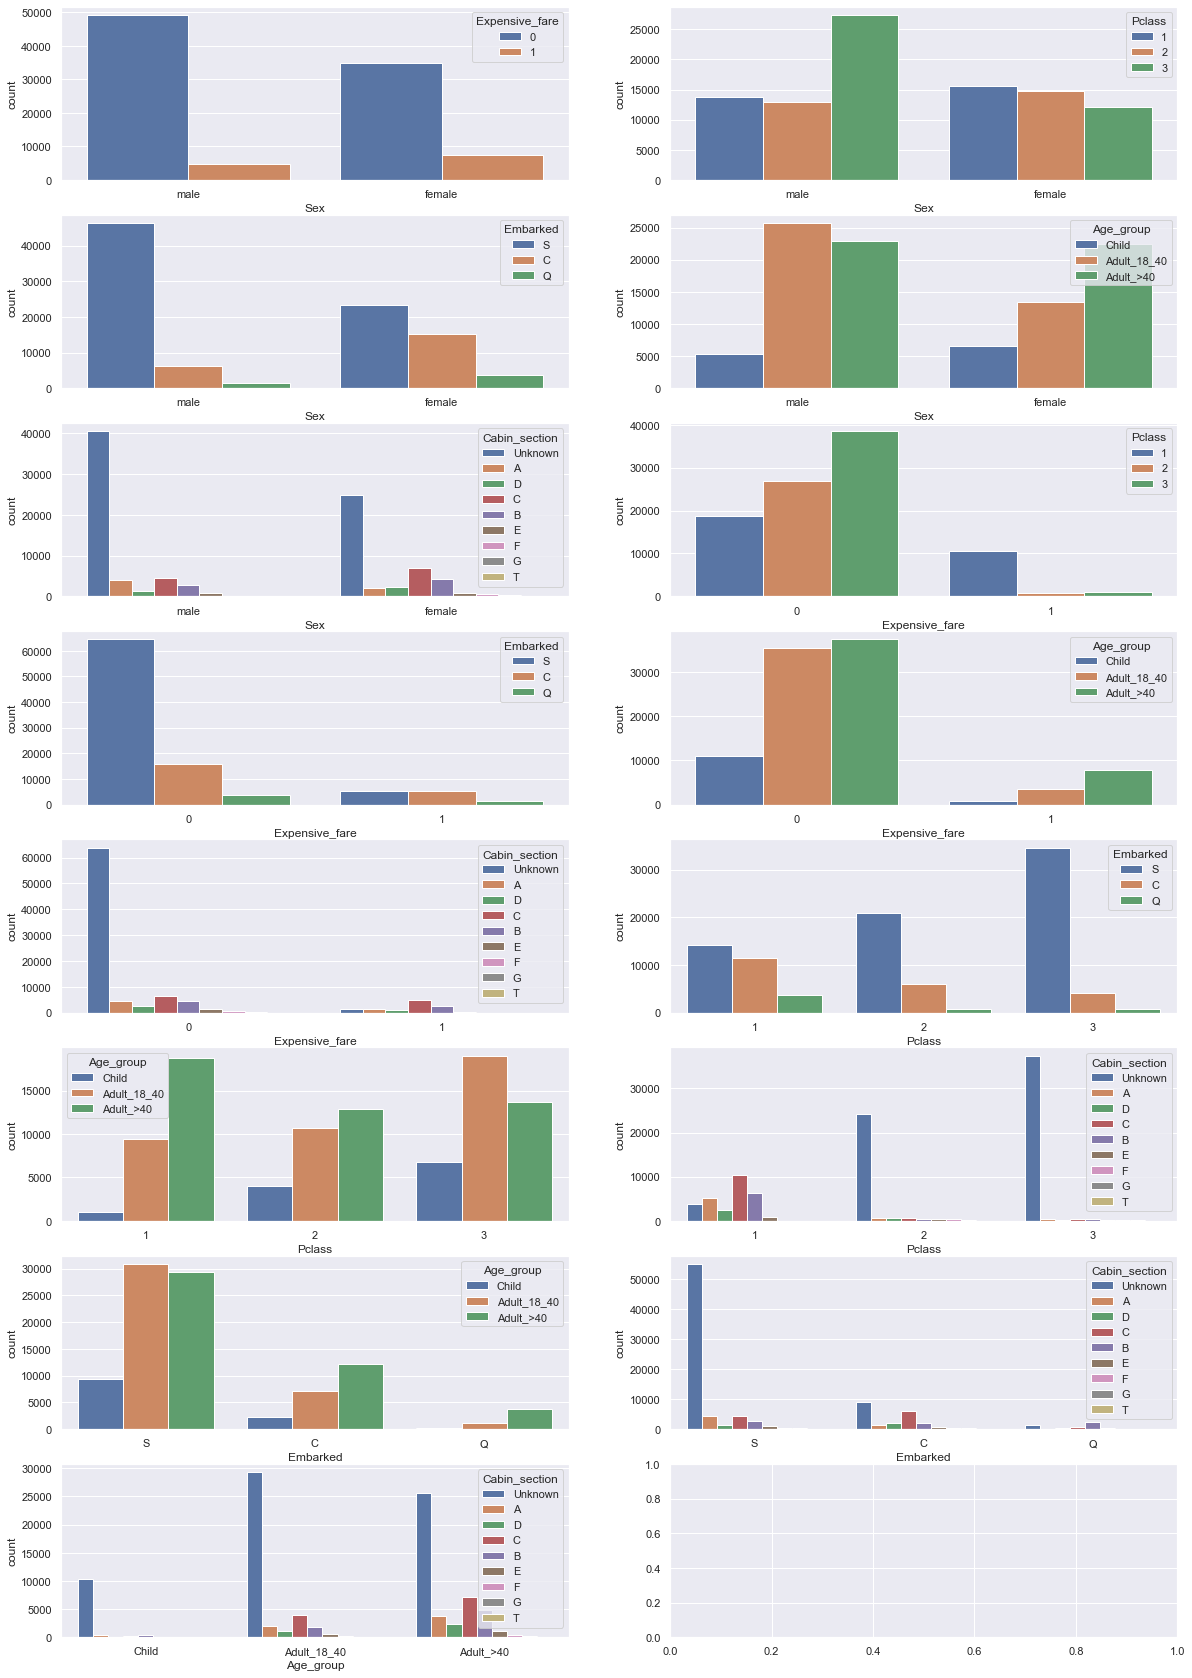

In [85]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20, 30))

idx = 0
for i, j in itertools.combinations(cat_features, 2):
    sns.countplot(x=i, hue=j, data=data, ax=axes[idx // 2, idx % 2])
    idx += 1

***Observations:***

1. Passengers from the 3rd class are mostly males

### Projection on 2d surface 

In [87]:
columns_for_projection = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin_section']
projection_data = data[columns_for_projection]
projection_data.loc[:, 'Sex'] = projection_data.Sex.map({'male': 1, 'female': 0})

In [88]:
projection_data = pd.concat([projection_data, pd.get_dummies(projection_data.Embarked, prefix='Embarked'), pd.get_dummies(projection_data.Cabin_section, prefix='Cabin_section')], axis=1)
projection_data.drop(['Embarked', 'Cabin_section'], axis=1, inplace=True)

In [89]:
scaler = StandardScaler()
projection_data_scaled = scaler.fit_transform(projection_data)

#### Random projection

In [90]:
projection = random_projection.SparseRandomProjection(n_components = 2, random_state = 0)
projection_data_2d = projection.fit_transform(projection_data_scaled)

<AxesSubplot:>

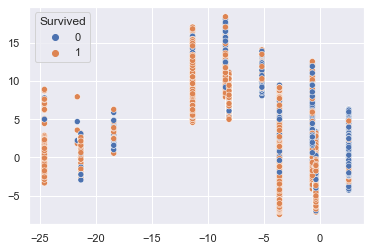

In [91]:
sns.scatterplot(x=projection_data_2d[:, 0], y=projection_data_2d[:, 1], hue=data.Survived)

#### PCA

In [92]:
pca = PCA(n_components = 2, random_state = 0)
data_2d_pca = pca.fit_transform(projection_data_scaled)

<AxesSubplot:>

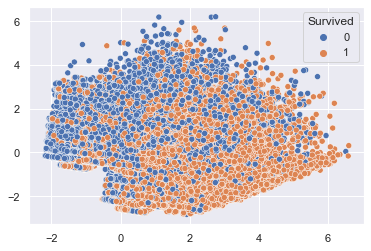

In [93]:
sns.scatterplot(x=data_2d_pca[:, 0], y=data_2d_pca[:, 1], hue=data.Survived)

<AxesSubplot:>

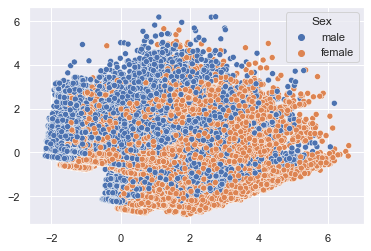

In [96]:
sns.scatterplot(x=data_2d_pca[:, 0], y=data_2d_pca[:, 1], hue=data.Sex)

<AxesSubplot:>

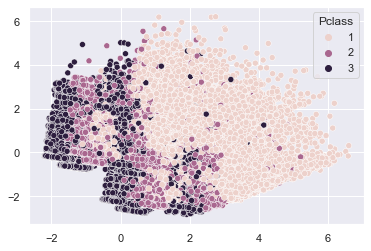

In [97]:
sns.scatterplot(x=data_2d_pca[:, 0], y=data_2d_pca[:, 1], hue=data.Pclass)

<AxesSubplot:>

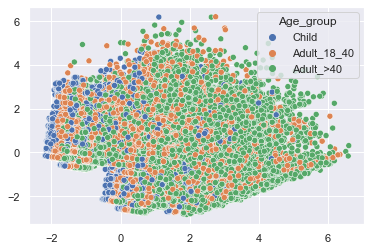

In [98]:
sns.scatterplot(x=data_2d_pca[:, 0], y=data_2d_pca[:, 1], hue=data.Age_group)

#### TSNE

In [94]:
%%time
tsne = manifold.TSNE(n_components = 2, init = 'pca', random_state = 0)
data_2d_tsne = tsne.fit_transform(projection_data_scaled)

Wall time: 16min 51s


<AxesSubplot:>

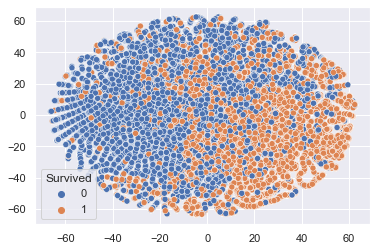

In [95]:
sns.scatterplot(x=data_2d_tsne[:, 0], y=data_2d_tsne[:, 1], hue=data.Survived)

<AxesSubplot:>

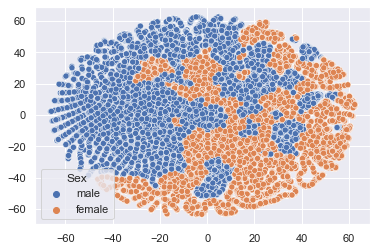

In [99]:
sns.scatterplot(x=data_2d_tsne[:, 0], y=data_2d_tsne[:, 1], hue=data.Sex)

<AxesSubplot:>

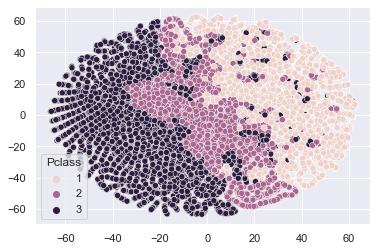

In [100]:
sns.scatterplot(x=data_2d_tsne[:, 0], y=data_2d_tsne[:, 1], hue=data.Pclass)

<AxesSubplot:>

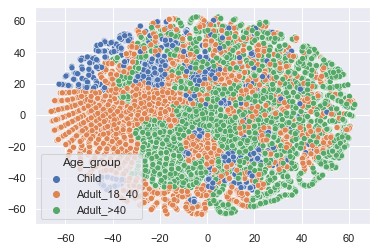

In [101]:
sns.scatterplot(x=data_2d_tsne[:, 0], y=data_2d_tsne[:, 1], hue=data.Age_group)

# Summary

According to the observations in Data exploration part we can make a guess about existance of the following possible main insights:

- The passengers from the 1st and 2nd classes had the best chances to survive.
- Passengers with expensive fares had more chances to survive which is expected as the passengers of the 1st class had most ratio of expensive_fares.
- Females had better chances to surivive than males. This sounds reasonable as the women were rescued first.
- The older Passengers had more chances to survive. This can be explained by the fact that older passengers mostly were in 1st class and also they had more expensive fare.
- Passengers embarked in Cherbourg port have the best chances to survive. Passengers located in Cabin_Section C had the best chances to survive. Both this insights can be explained by the location specialty of the ship. Perhaps the passengers embarked in Cherbourg were clustered in the part of the ship that was the best place for evacuation. The same logic can be applied for Cabin section C.
- Top survived categories for Pclass and Age_group: Adults more than 40 years old from the 1st class and Children from the 2nd class.
- Passengers with given information about the cabin had more chances to survive than passengers with unknown cabin. This can be specialty of data collection as survived passengers could provide information about the cabin they were located whilst not survived passengers couldn't do it.
- the average number of Parch is greater for survived. Probably parents were saved with children together which makes sense.

*In case of any questions please feel free to contact me on* https://discordapp.com/users/422320477084712960 or https://t.me/VladBGC